### Import các thư viện cần dùng

In [ ]:
import pandas as pd
import numpy as np
import chardet
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 

### Ghép thêm bảng vào dữ liệu gốc

In [ ]:
#Kiểm tra định dạng file CSV muôn gộp vào dữ liệu gốc
with open(r'data/DimProductSubcategory.csv', 'rb') as f:
  result = chardet.detect(f.read(100000))  # Đọc 100KB đầu tiên
  print(result)  # Xem file có encoding gì

{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


In [ ]:
df_subcategory = pd.read_csv(r'data/DimProductSubcategory.csv', 
                 delimiter="|", encoding="UTF-16", header=None)
#Xóa cột đầu tiên vì đây là index
df_subcategory = df_subcategory.iloc[:, 1:]
#Đặt tên cho các cột
df_subcategory.columns = ['ProductSubcategoryKey', 'EnglishProductSubcategoryName', 
                          'SpanishProductSubcategoryName', 
                          'FrenchProductSubcategoryName', 'ProductCategoryKey']

In [ ]:
#Tạo dataset mới có bảng DimProductSubcategory từ df_subcategory và dataset gốc
df_origin = pd.ExcelFile('data/Dataset_Round2_2021_Sales.xlsx')
with pd.ExcelWriter('data/Dataset_DM&DW.xlsx', engine="openpyxl") as writer:
  # Ghi lại từng sheet cũ
  for sheet_name in df_origin.sheet_names:
    df_for = pd.read_excel(df_origin, sheet_name=sheet_name)
    df_for.to_excel(writer, sheet_name=sheet_name, index=False)  # Ghi lại sheet cũ
  # Thêm sheet mới từ CSV
  df_subcategory.to_excel(writer, sheet_name="DimProductSubcategory", index=False)

In [6]:
#Kiểm tra xem đã có sheet DimProductSubcategory chưa
df_new = pd.ExcelFile('Dataset_DM&DW.xlsx')
df_new.sheet_names 

['Product',
 'DimCurrency',
 'DimCustomer',
 'DimDate',
 'FactInternetSales',
 'SaleReason',
 'FactInternetSalesReason',
 'DimPromotion',
 'DimProductSubcategory']

### Đọc dữ liệu

In [3]:
df_product = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='Product')
df_subcategory = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='DimProductSubcategory')
df_customer = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='DimCustomer')
df_internetsale = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='FactInternetSales')
df_date = pd.read_excel('data/Dataset_DM&DW.xlsx', sheet_name='DimDate')

### Association Rules

In [8]:
df_product.shape

(771, 36)

In [9]:
print(df_product.duplicated().sum())

111


In [10]:
df_product[df_product.duplicated()][['ProductKey', 'EnglishProductName']]

,ProductKey,EnglishProductName
295,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
297,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
299,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
301,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
303,AB3769ABF265BD53188CC112D9C23204826C0281EB0914...,"כל מסגרת מיוצרת ידנית במפעל שלנו ב- Bothell, ל..."
...,...,...
749,853207C067902C999EE8910889483499660FC00280411B...,אופניים אלה מספקים רמת ביצועים גבוהה במחיר סבי...
751,853207C067902C999EE8910889483499660FC00280411B...,אופניים אלה מספקים רמת ביצועים גבוהה במחיר סבי...
766,E2312F1A47E4E68F1C41550D93160944832264D41918D4...,"אופני מבוגרים למתחילים; מציעים רכיבה נוחה ""מחו..."
768,E2312F1A47E4E68F1C41550D93160944832264D41918D4...,"אופני מבוגרים למתחילים; מציעים רכיבה נוחה ""מחו..."


In [12]:
print(df_product['ProductKey'].unique())

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
 'C4A5076C811144C307604193D827EE3004ED205B5228577095DA3F0801FA780FFDCD863138FFC067F28B313C77B2494735AC813FB484023C832D14CF078CC001180108A841C1D96E20A4000B608D84A8437166C33074147800D686C746B965130198830E94C082B1530AC000A0FE260EA4ED0C28420F10C1348C023278438D87413621D2A8DD27008C677C289190DB45C07C498AF98F155572159A853E941237484036108025608102F800062401D90D4114AC590E6042097841198439462CC02C1467E7147A4EAE39AE0D5E46F10A08D0420737521B90030838C16F7A2018940219A04104D4AABF020049D984B41C43921A58F60080A3FFDC38034A011858E622C0E46C80125580207C020244408B57C1A7BC00A2141C25E00100A8019E1CC202E4407192FFC587D03A619345FF14800C7C2C6AE50904BC401A70002D68C11D0C01D921000250C33058C20114C2E8FC1BBAB9E24D347A42FD9C8F10A2B4C7465024543708F116ACC11A94CA330CCF46A58019244A0EDC01000C801A108A84A0C2811010E2D27B4FF70BE038271E4488740AC02940C02064418A230109C0F716804103084118F8C0E1FDC391374093488AC4078C113531C4D8586CF405E00C822D59031728C1B26DC3A740C0515DC81380C1108464AB2F8

In [13]:
np.sort(df_internetsale['ProductKey'].unique())

array([214, 217, 222, 225, 228, 231, 234, 237, 310, 311, 312, 313, 314,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
       359, 360, 361, 362, 363, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
       389, 390, 463, 465, 467, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       528, 529, 530, 535, 536, 537, 538, 539, 540, 541, 560, 561, 562,
       563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575,
       576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588,
       589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 604,
       605, 606], dtype=int64)

In [14]:
#Chuyển đổi kiểu của ProductKey trong df_product về number
df_product['ProductKey'] = pd.to_numeric(df_product['ProductKey'], errors='coerce')
#Xóa các dòng có giá trị NaN 
df_product = df_product.dropna(subset=['ProductKey'])

print(f'Số dòng của df_product sau khi xóa NaN: {df_product.shape[0]}')
print(f'Số dòng trùng lặp: {df_product.duplicated().sum()}')


Số dòng của df_product sau khi xóa NaN: 606
Số dòng trùng lặp: 0


In [15]:
df_product[pd.isnull(
  df_product['ProductSubcategoryKey']
  )][['ProductKey', 'EnglishProductName', 'ProductSubcategoryKey']]

,ProductKey,EnglishProductName,ProductSubcategoryKey
0,1.0,Adjustable Race,NaN
1,2.0,Bearing Ball,NaN
2,3.0,BB Ball Bearing,NaN
3,4.0,Headset Ball Bearings,NaN
4,5.0,Blade,NaN
...,...,...,...
205,205.0,Seat Stays,NaN
206,206.0,Seat Tube,NaN
207,207.0,Top Tube,NaN
208,208.0,Tension Pulley,NaN


In [16]:
df_product[pd.isnull(df_product['ProductSubcategoryKey'])]['ProductKey'].unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [17]:
df_internetsale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProductKey             60398 non-null  int64  
 1   OrderDateKey           60398 non-null  int64  
 2   DueDateKey             60398 non-null  int64  
 3   ShipDateKey            60398 non-null  int64  
 4   CustomerKey            60398 non-null  int64  
 5   PromotionKey           60398 non-null  int64  
 6   CurrencyKey            60398 non-null  int64  
 7   SalesTerritoryKey      60398 non-null  int64  
 8   SalesOrderNumber       60398 non-null  object 
 9   SalesOrderLineNumber   60398 non-null  int64  
 10  RevisionNumber         60398 non-null  int64  
 11  OrderQuantity          60398 non-null  int64  
 12  UnitPrice              60398 non-null  float64
 13  ExtendedAmount         60398 non-null  float64
 14  UnitPriceDiscountPct   60398 non-null  int64  
 15  Di

In [18]:
#Nối bảng df_product với df_subcategory để lấy ProductSubcategoryName
df_newproduct = pd.merge(df_product, df_subcategory, 
                         on='ProductSubcategoryKey', 
                         how='left')
#Nối bảng df_internetsale với df_product để xây dựng giỏ hàng
df_internetsale_product = pd.merge(df_internetsale, df_newproduct, 
                                   on='ProductKey', how='inner')

print(df_internetsale_product.shape)

(60398, 65)


In [19]:
#Tạo giỏ hàng của khách hàng
df_cart = df_internetsale_product.groupby(
  ['OrderDate','CustomerKey']).agg(
    Subcategories=('EnglishProductSubcategoryName', 
                   lambda x: [item.strip() for item in x])).reset_index()
df_cart

,OrderDate,CustomerKey,Subcategories
0,2010-12-29 00:00:00,11003,[Mountain Bikes]
1,2010-12-29 00:00:00,14501,[Road Bikes]
2,2010-12-29 00:00:00,21768,[Road Bikes]
3,2010-12-29 00:00:00,25863,[Mountain Bikes]
4,2010-12-29 00:00:00,28389,[Mountain Bikes]
...,...,...,...
27613,2014-01-28 00:00:00,24704,[Tires and Tubes]
27614,2014-01-28 00:00:00,26564,"[Tires and Tubes, Gloves, Tires and Tubes]"
27615,2014-01-28 00:00:00,26832,"[Tires and Tubes, Tires and Tubes, Hydration P..."
27616,2014-01-28 00:00:00,27686,"[Tires and Tubes, Tires and Tubes, Helmets]"


In [ ]:
#One-hot encoding cho Subcategories
te = TransactionEncoder()
te_ary = te.fit_transform(df_cart['Subcategories'].tolist())
df_cart_te = pd.DataFrame(te_ary, columns=te.columns_)
df_cart_te.head()

,Bike Racks,Bike Stands,Bottles and Cages,Caps,Cleaners,Fenders,Gloves,Helmets,Hydration Packs,Jerseys,Mountain Bikes,Road Bikes,Shorts,Socks,Tires and Tubes,Touring Bikes,Vests
0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [23]:
#Xây dựng luật kết hợp với thuật toán Apriori
frequent_itemsets = apriori(df_cart_te, min_support=0.01, use_colnames=True)
df_rules=association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x:len(x))

In [24]:
df_rules.iloc[:, :7].sort_values('confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
1,(Cleaners),(Tires and Tubes),0.032877,0.356434,0.016475,0.501101,1.405873
11,"(Gloves, Tires and Tubes)",(Helmets),0.020168,0.233145,0.010102,0.500898,2.148438
13,"(Jerseys, Tires and Tubes)",(Helmets),0.023897,0.233145,0.011116,0.465152,1.995116
10,"(Gloves, Helmets)",(Tires and Tubes),0.021797,0.356434,0.010102,0.463455,1.300254
0,(Hydration Packs),(Bottles and Cages),0.026541,0.172605,0.011985,0.451569,2.616201
12,"(Helmets, Jerseys)",(Tires and Tubes),0.025129,0.356434,0.011116,0.442363,1.241079
5,(Helmets),(Tires and Tubes),0.233145,0.356434,0.100261,0.430036,1.206494
2,(Fenders),(Mountain Bikes),0.076798,0.179955,0.032515,0.423385,2.352727
3,(Gloves),(Helmets),0.051778,0.233145,0.021797,0.420979,1.805653
6,(Touring Bikes),(Helmets),0.078463,0.233145,0.032334,0.412090,1.767528


In [25]:
frequent_itemsets

,support,itemsets,length
0,0.011876,(Bike Racks),1
1,0.172605,(Bottles and Cages),1
2,0.079296,(Caps),1
3,0.032877,(Cleaners),1
4,0.076798,(Fenders),1
5,0.051778,(Gloves),1
6,0.233145,(Helmets),1
7,0.026541,(Hydration Packs),1
8,0.120646,(Jerseys),1
9,0.179955,(Mountain Bikes),1


In [26]:
#Xem các đặc điểm các nhóm khách hàng của từng luật
def transaction_contains_items(transaction, itemset):
  return itemset.issubset(set(transaction))

customer_mapping = []
for idx, row in df_rules.iterrows():
  antecedents = row['antecedents']
  consequents = row['consequents']
  combined_items = antecedents.union(consequents)
  matching_customers = df_cart[
    df_cart['Subcategories'].apply(
      lambda x: transaction_contains_items(x, combined_items))
    ]['CustomerKey'].unique()
  customer_mapping.append({'rule_idx': idx,
                           'antecedents': ', '.join(antecedents),
                           'consequents': ', '.join(consequents),
                           'customers': matching_customers})
df_customer_rules = pd.DataFrame(customer_mapping)
df_customer_rules_expanded = df_customer_rules.explode('customers')
df_customer_rules_expanded = df_customer_rules_expanded.merge(
  df_customer, left_on='customers', right_on='CustomerKey', how='left'
)
customer_summary = df_customer_rules_expanded.groupby(
  ['antecedents', 'consequents']
  ).agg({'YearlyIncome': 'mean', 
         'Gender': lambda x: x.mode()[0] if not x.empty else 'Unknown'
}).reset_index()

customer_summary

,antecedents,consequents,YearlyIncome,Gender
0,Cleaners,Tires and Tubes,60837.104072,F
1,Fenders,Mountain Bikes,69832.962138,F
2,Gloves,Helmets,62702.702703,M
3,Gloves,Tires and Tubes,58981.481481,M
4,"Gloves, Helmets",Tires and Tubes,63705.035971,M
5,"Gloves, Tires and Tubes",Helmets,63705.035971,M
6,Helmets,Tires and Tubes,56650.000000,M
7,"Helmets, Jerseys",Tires and Tubes,59834.983498,F
8,Hydration Packs,Bottles and Cages,61178.247734,F
9,"Jerseys, Tires and Tubes",Helmets,59834.983498,F


### K-Means Clustering

In [4]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerKey           18484 non-null  int64 
 1   GeographyKey          18484 non-null  int64 
 2   CustomerAlternateKey  18484 non-null  object
 3   Title                 101 non-null    object
 4   FirstName             18484 non-null  object
 5   MiddleName            10654 non-null  object
 6   LastName              18484 non-null  object
 7   NameStyle             18484 non-null  bool  
 8   BirthDate             18484 non-null  object
 9   MaritalStatus         18484 non-null  object
 10  Suffix                3 non-null      object
 11  Gender                18484 non-null  object
 12  EmailAddress          18484 non-null  object
 13  YearlyIncome          18484 non-null  int64 
 14  TotalChildren         18484 non-null  int64 
 15  NumberChildrenAtHome  18484 non-null

In [190]:
print(df_customer.duplicated().sum())

0


In [191]:
#Tạo 1 data frame trích xuất dữ liệu cần sử dụng để làm đặc trưng của mô hình.
df_group_customer = df_internetsale.groupby('CustomerKey').agg(
  MaxOrderDate=('OrderDate', 'max'),
  TotalAmount=('SalesAmount', 'sum'),
  CountOrder=('OrderQuantity', 'sum'),
  Diversity=('ProductKey', 'nunique')
).reset_index()

#Kiểm tra giá trị null, số hàng và cột của data frame vừa trích xuất và df_customer
print(f"Hình dạng của new df: {df_group_customer.shape}")
print(f"Hình dạng của df_customer: {df_customer.shape}")
print(f"Số giá trị null của CustomerKey df_group_customer:\
  {df_group_customer['CustomerKey'].isnull().sum()}")
print(f"Số giá trị null của CustomerKey df_customer:\
  {df_customer['CustomerKey'].isnull().sum()}")

Hình dạng của new df: (18484, 5)
Hình dạng của df_customer: (18484, 29)
Số giá trị null của CustomerKey df_group_customer:  0
Số giá trị null của CustomerKey df_customer:  0


In [192]:
#Nối data frame vừa tạo với df_customer
df_new_customer = df_customer.merge(df_group_customer, on='CustomerKey', how='inner')

In [193]:
last_orderdate = pd.to_datetime(df_internetsale['OrderDate'].max())
#Tạo cột số ngày mua hàng từ đơn hàng cuối cùng tới ngày gần nhất của dữ liệu
df_new_customer['LastToPresent'] = (
  last_orderdate - pd.to_datetime(df_new_customer['MaxOrderDate'])
  ).dt.days
#Tạo cột tính tuổi của khách hàng dựa trên ngày sinh
df_new_customer['Age'] = (
  (pd.to_datetime(last_orderdate) - pd.to_datetime(df_new_customer['BirthDate'])
   ).dt.days // 365).round()
#Tạo cột tính vòng đời của khách hàng theo đơn vị ngày
df_new_customer['CustomerLife'] = (
  pd.to_datetime(df_new_customer['MaxOrderDate']) - 
  pd.to_datetime(df_new_customer['DateFirstPurchase'])
  ).dt.days

In [194]:
#Trích xuất đặc trưng cho mô hình 
df_customer_kmean = df_new_customer[
  ['MaritalStatus', 'Gender', 'YearlyIncome', 'TotalChildren',
   'NumberChildrenAtHome', 'EnglishEducation', 'EnglishOccupation', 'HouseOwnerFlag',
   'NumberCarsOwned', 'CommuteDistance', 'Age', 'LastToPresent', 'CustomerLife',
   'Diversity', 'CountOrder', 'TotalAmount']]

In [195]:
#Mã hóa các đặc trưng
df_customer_kmean['CommuteDistance'] = df_customer_kmean['CommuteDistance'].replace({
    '0-1 Miles': 0,
    '1-2 Miles': 1,
    '2-5 Miles': 2,
    '5-10 Miles': 3,
    '10+ Miles': 4
}).astype(int)
df_customer_kmean['MaritalStatus'] = \
  df_customer_kmean['MaritalStatus'].replace({'M': 1, 'S': 0}).astype(int)
df_customer_kmean['Gender'] = \
  df_customer_kmean['Gender'].replace({'F': 0, 'M': 1}).astype(int)
df_customer_kmean['Education'] = df_customer_kmean['EnglishEducation'].replace({
    'Partial High School': 0,
    'High School': 1,
    'Partial College': 2,
    'Bachelors': 3,
    'Graduate Degree': 4
}).astype(int)

le = LabelEncoder()
df_customer_kmean['Occupation'] = \
  le.fit_transform(df_customer_kmean['EnglishOccupation'])

# #Xóa các cột không dùng tới
df_customer_kmean = df_customer_kmean.drop(
  columns=['EnglishEducation', 'EnglishOccupation'])

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\2549048927.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_customer_kmean['CommuteDistance'] = df_customer_kmean['CommuteDistance'].replace({
C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\2549048927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer_kmean['CommuteDistance'] = df_customer_kmean['CommuteDistance'].replace({
C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\2549048927.py:10: FutureWarning: Downcasting behavior in `replace` is deprecate

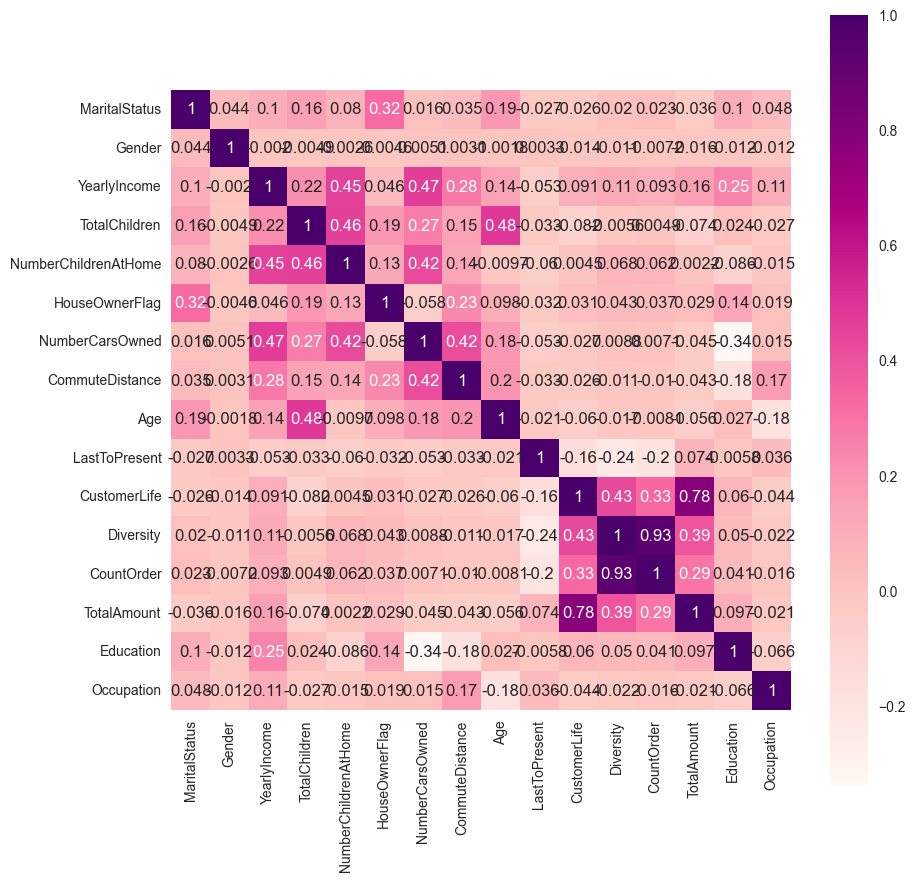

In [196]:
#Biểu đồ tương quan giữa các đặc trưng
plt.figure(figsize=(10,10))
sns.heatmap(df_customer_kmean.corr(),annot=True,square=True,cmap='RdPu')
plt.show()

In [ ]:
#Chuẩn hóa dữ liệu bằng phương pháp Z-score
scaler = StandardScaler()
df_customer_kmean_scaled = scaler.fit_transform(df_customer_kmean)
X_scaled = pd.DataFrame(df_customer_kmean_scaled, 
                        columns=df_customer_kmean.columns)

In [198]:
#Giảm chiều dữ liệu với PCA
pca = PCA(random_state=21, n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [92]:
#Mô tả dữ liệu sau khi giảm chiều
df_X_pca = pd.DataFrame(X_pca, columns=['col1', 'col2', 'col3'])
df_X_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,18484.0,-7.380665e-17,1.648795,-3.277957,-1.162534,-0.313037,0.845521,18.966794
col2,18484.0,3.382805e-17,1.594914,-5.273838,-1.145266,0.176643,1.143819,7.291442
col3,18484.0,2.152694e-17,1.249677,-3.559551,-0.915434,-0.007730,0.896872,4.330502


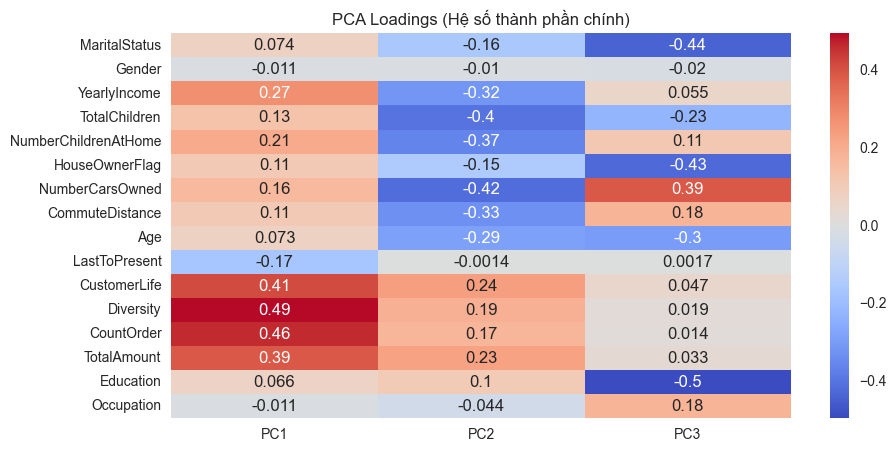

In [93]:
#Xem mức độ đóng góp của các thành phần chính
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], 
                        index=X_scaled.columns)
plt.figure(figsize=(10, 5))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings (Hệ số thành phần chính)")
plt.show()

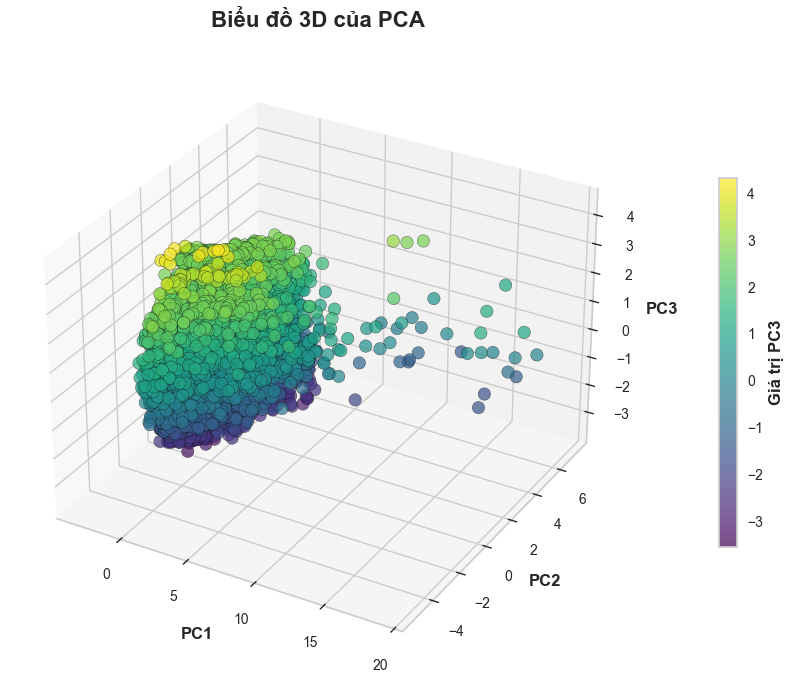

In [199]:
#Biểu đồ 3D thể hiện sự phân bố của dữ liệu sau giảm chiều
fig = plt.figure(figsize=(12, 8), facecolor='white')
ax = fig.add_subplot(111, projection='3d', facecolor='none')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=X_pca[:, 2],
                     cmap="viridis",
                     edgecolors='k',
                     s=80,
                     alpha=0.7,
                     depthshade=True)

ax.set_xlabel("PC1", fontsize=12, labelpad=10, fontweight='bold')
ax.set_ylabel("PC2", fontsize=12, labelpad=10, fontweight='bold')
ax.set_zlabel("PC3", fontsize=12, labelpad=10, fontweight='bold')

ax.set_title("Biểu đồ 3D của PCA", fontsize=16, pad=20, fontweight='bold')

legend = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
legend.set_label("Giá trị PC3", fontsize=12, fontweight='bold')
legend.ax.tick_params(labelsize=10)

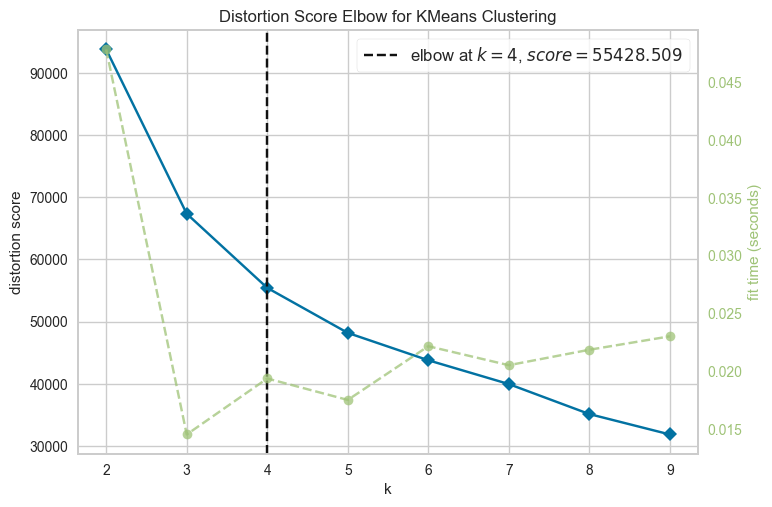

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [200]:
#Tìm K trên dữ liệu đã giảm chiều
kmean_test = KMeans(random_state=21, n_init='auto', max_iter=500)
visualizer = KElbowVisualizer(kmean_test, k=(2,10))
visualizer.fit(X_pca)
visualizer.show()

In [201]:
#Xây dựng mô hình KMeans với số cụm là 4
kmeans = KMeans(n_clusters=4, random_state=21, max_iter=500, n_init='auto')
kmeans.fit(X_pca)

KMeans(max_iter=500, n_clusters=4, random_state=21)

In [98]:
#Đánh giá độ tốt của cụm
print(silhouette_score(X_pca, kmeans.labels_))
print(davies_bouldin_score(X_pca, kmeans.labels_))

0.28792411240109883
1.0574171802628307


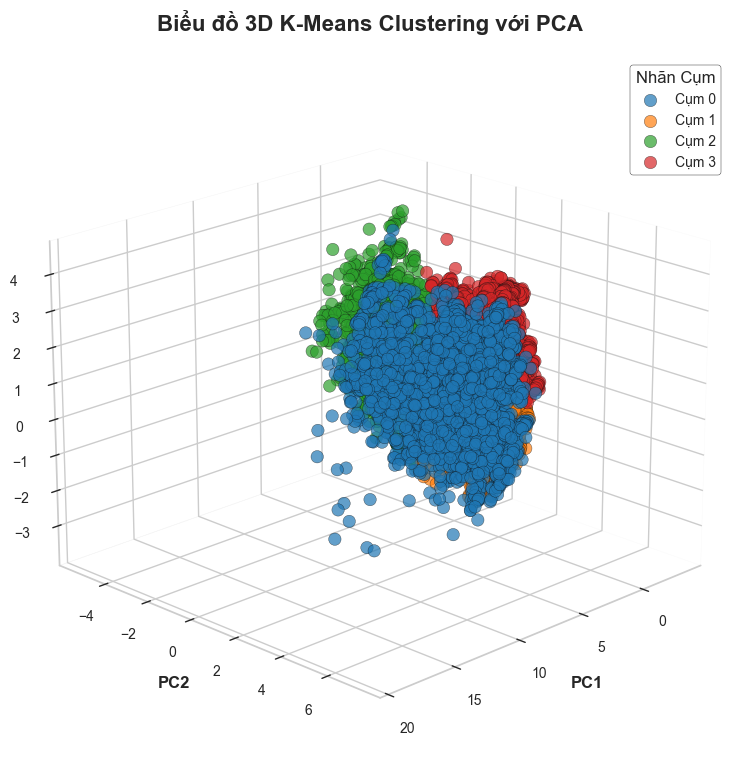

In [99]:
#Biểu đồ 3D thể hiện sự phân bố dữ liệu của các cụm
fig = plt.figure(figsize=(12, 8), facecolor='white')
ax = fig.add_subplot(111, projection='3d', facecolor='none')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

for i in np.unique(kmeans.labels_):
  ax.scatter(X_pca[kmeans.labels_ == i, 0],
              X_pca[kmeans.labels_ == i, 1],
              X_pca[kmeans.labels_ == i, 2],
              label=f'Cụm {i}',
              s=80,
              alpha=0.7,
              edgecolors='k',
              c=colors[i % len(colors)],
              depthshade=True)

ax.set_xlabel("PC1", fontsize=12, labelpad=10, fontweight='bold')
ax.set_ylabel("PC2", fontsize=12, labelpad=10, fontweight='bold')
ax.set_zlabel("PC3", fontsize=12, labelpad=10, fontweight='bold')

ax.set_title("Biểu đồ 3D K-Means Clustering với PCA", fontsize=16, pad=20, fontweight='bold')

ax.legend(title="Nhãn Cụm",
          title_fontsize=12,
          fontsize=10,
          loc='upper right',
          frameon=True,
          edgecolor='black',
          facecolor='white',
          framealpha=0.9)

ax.view_init(elev=20, azim=45)

ax.grid(True, linestyle='--', alpha=0.5)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.dist = 12

plt.tight_layout()
plt.show()

In [202]:
pd.DataFrame(kmeans.labels_, columns=['Cluster']).value_counts().sort_index()

Cluster
0          3424
1          4889
2          5104
3          5067
Name: count, dtype: int64

In [206]:
#Ghép các cụm vào Data Frame
df_new_customer['Cluster'] = kmeans.labels_

In [ ]:
# Tính đặc điểm trung bình của các đặc trưng trong từng cụm
df_new_customer.groupby('Cluster').mean(numeric_only=True)

,CustomerKey,GeographyKey,NameStyle,YearlyIncome,TotalChildren,NumberChildrenAtHome,HouseOwnerFlag,NumberCarsOwned,TotalAmount,CountOrder,Diversity,LastToPresent,Age,CustomerLife
Cluster,,,,,,,,,,,,,,
0,16952.209988,173.849591,0.0,66577.102804,1.608645,1.006133,0.716998,1.425818,4687.984637,5.881717,5.544685,146.192465,43.157126,564.221379
1,20651.329106,283.762733,0.0,45336.469626,1.613622,0.435876,0.865412,0.571078,1103.822633,2.680098,2.669462,210.042340,45.238699,72.129474
2,20724.515478,279.832092,0.0,79427.899687,3.263127,2.174569,0.826998,2.468848,724.709367,2.775470,2.758033,176.195729,50.995690,61.458072
3,21582.246694,267.855536,0.0,40305.900928,0.797119,0.371818,0.314782,1.480363,831.164863,2.563647,2.553385,211.734360,37.370831,61.446221


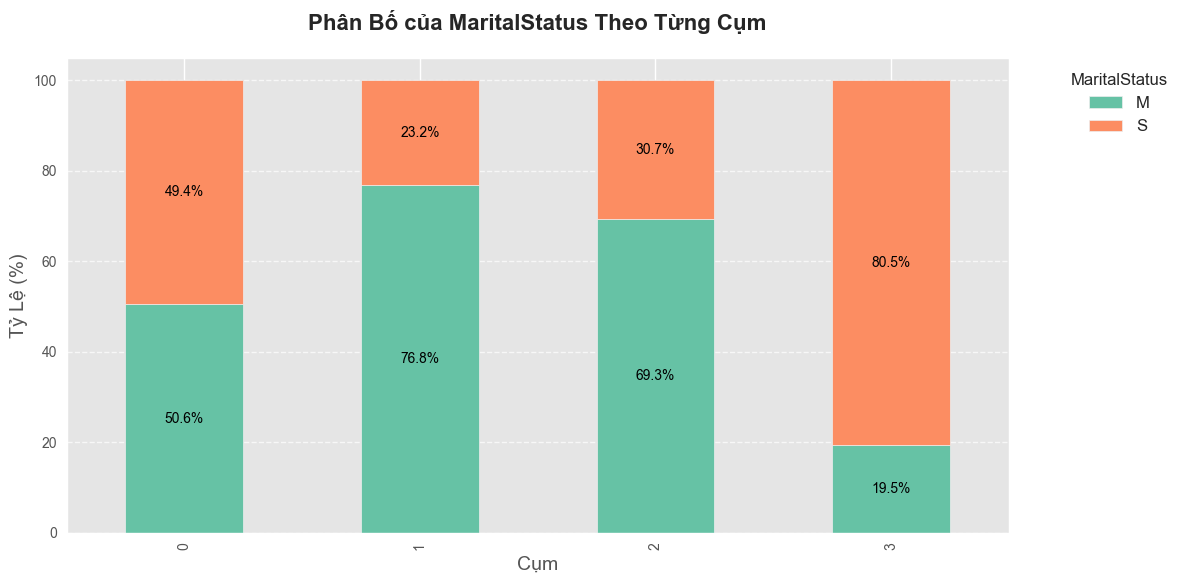

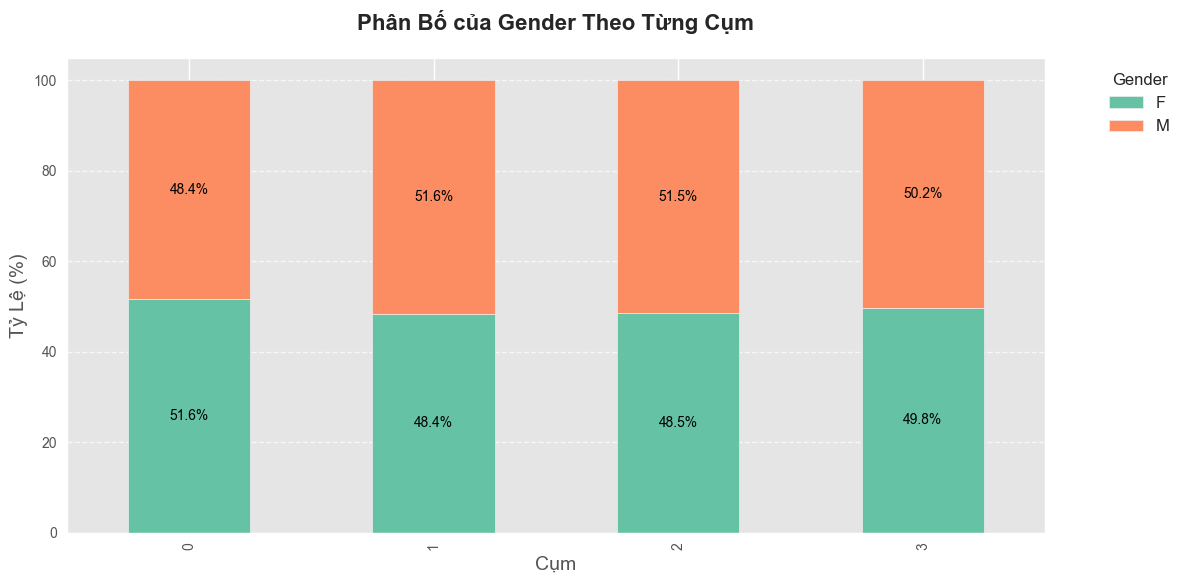

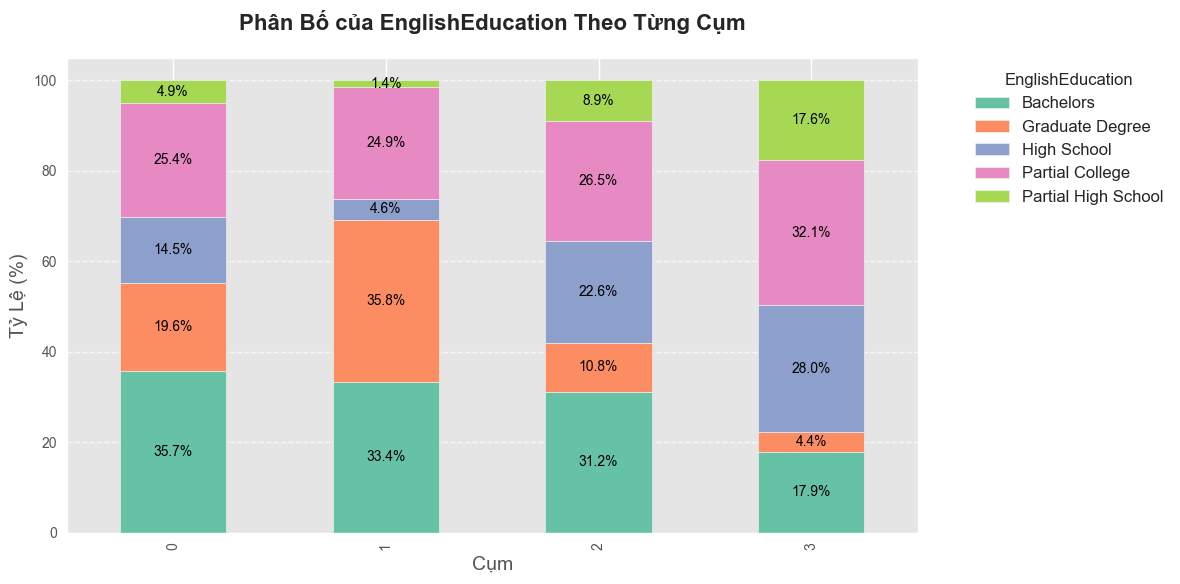

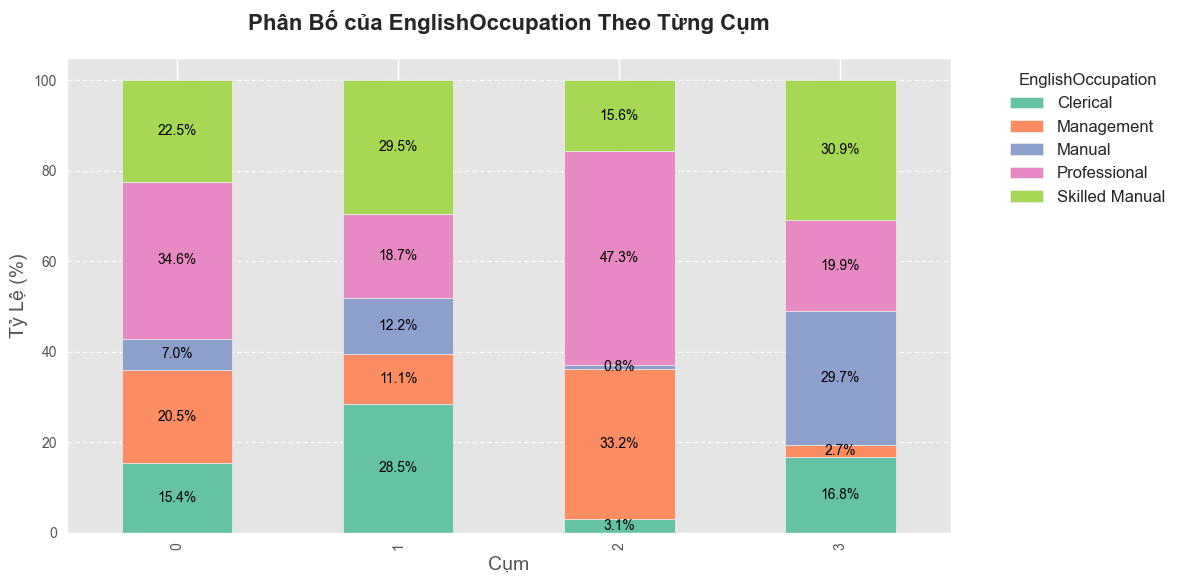

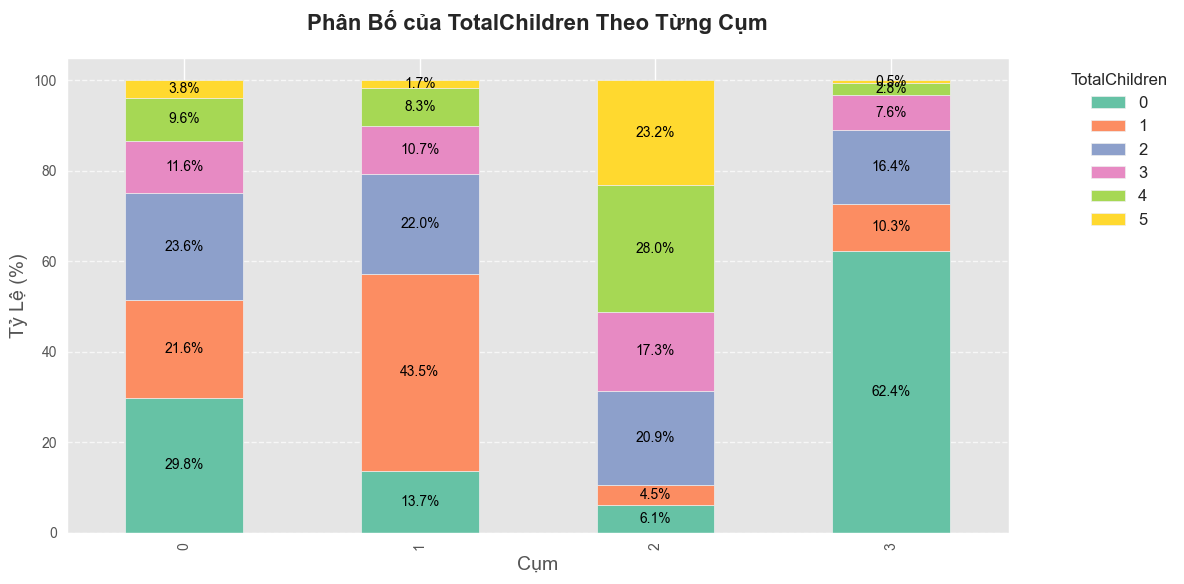

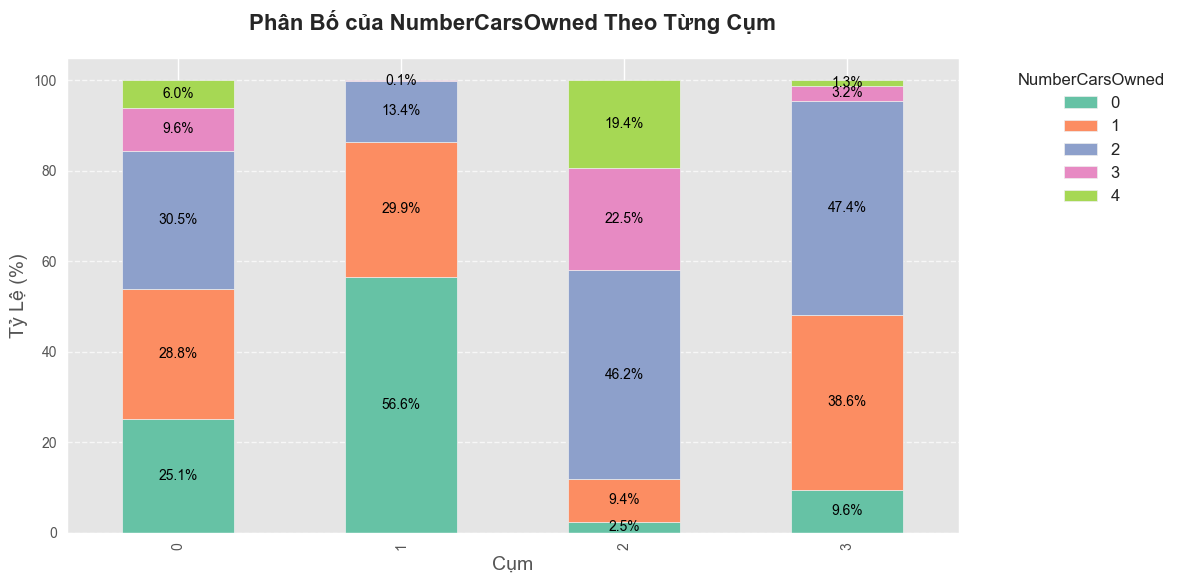

In [227]:
plt.style.use('ggplot')  
sns.set_palette("Set2") 
plt.rcParams['figure.figsize'] = (12, 6)  
plt.rcParams['font.size'] = 12  
plt.rcParams['axes.titlesize'] = 16  
plt.rcParams['axes.labelsize'] = 14  

categorical_columns = ['MaritalStatus', 'Gender', 'EnglishEducation', 'EnglishOccupation', 'TotalChildren', 'NumberCarsOwned']
for col in categorical_columns:
  distribution = df_new_customer.groupby('Cluster')[col].value_counts(normalize=True).unstack().fillna(0) * 100
  fig, ax = plt.subplots(figsize=(12, 6))
  distribution.plot(kind='bar', stacked=True, ax=ax)
  ax.set_title(f'Phân Bố của {col} Theo Từng Cụm', fontsize=16, fontweight='bold', pad=20)
  ax.set_xlabel('Cụm', fontsize=14)
  ax.set_ylabel('Tỷ Lệ (%)', fontsize=14)
  ax.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
  ax.grid(True, axis='y', linestyle='--', alpha=0.7)
  for i in range(distribution.shape[0]):  
    cumulative_height = 0  
    for j in range(distribution.shape[1]):  
      value = distribution.iloc[i, j]
      if value > 0:  
        cumulative_height += value
        ax.text(i, cumulative_height - value/2, f'{value:.1f}%', 
          ha='center', va='center', fontsize=10, color='black')

  plt.tight_layout()
  plt.show()

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




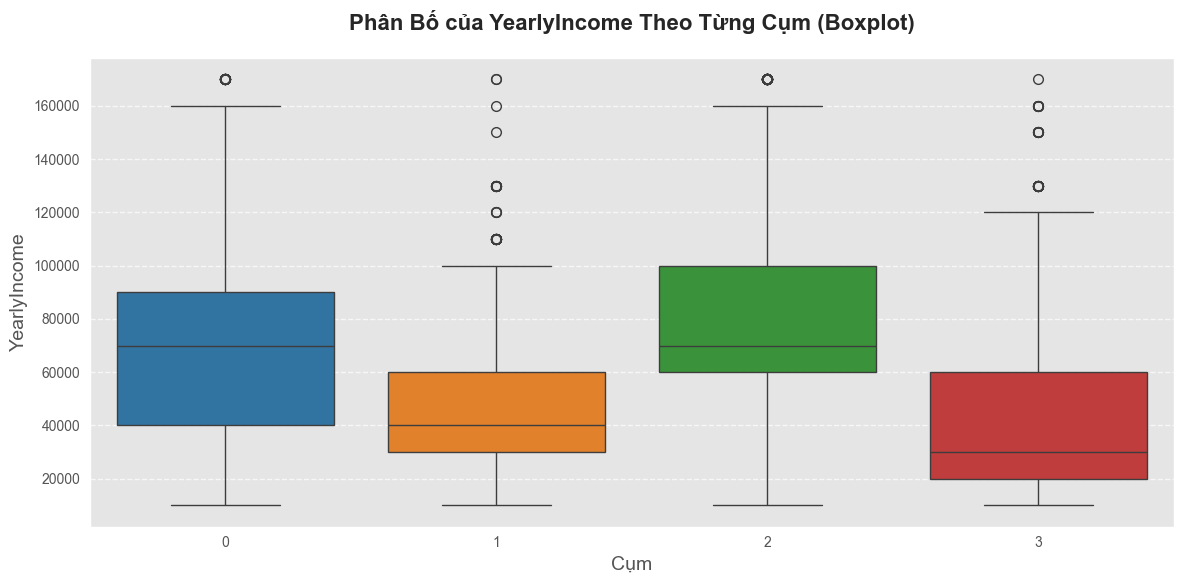

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




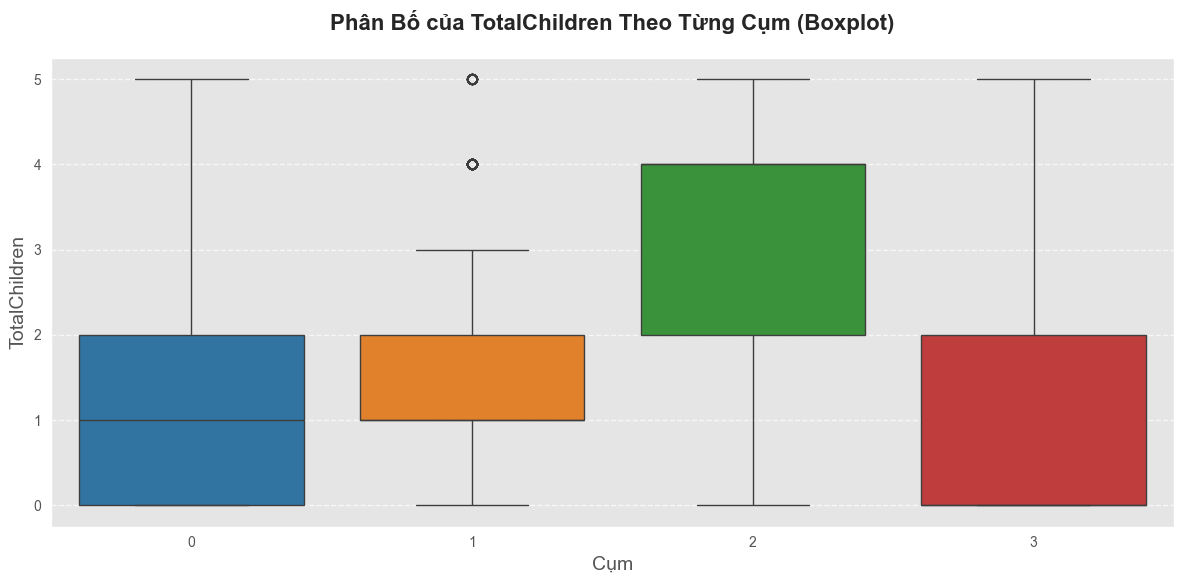

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




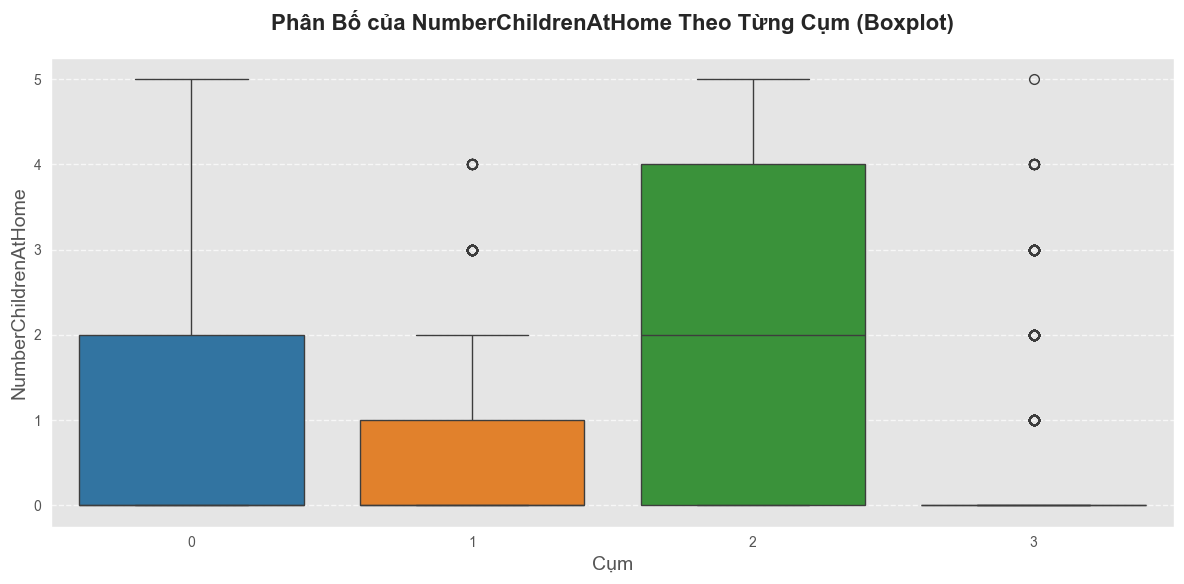

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




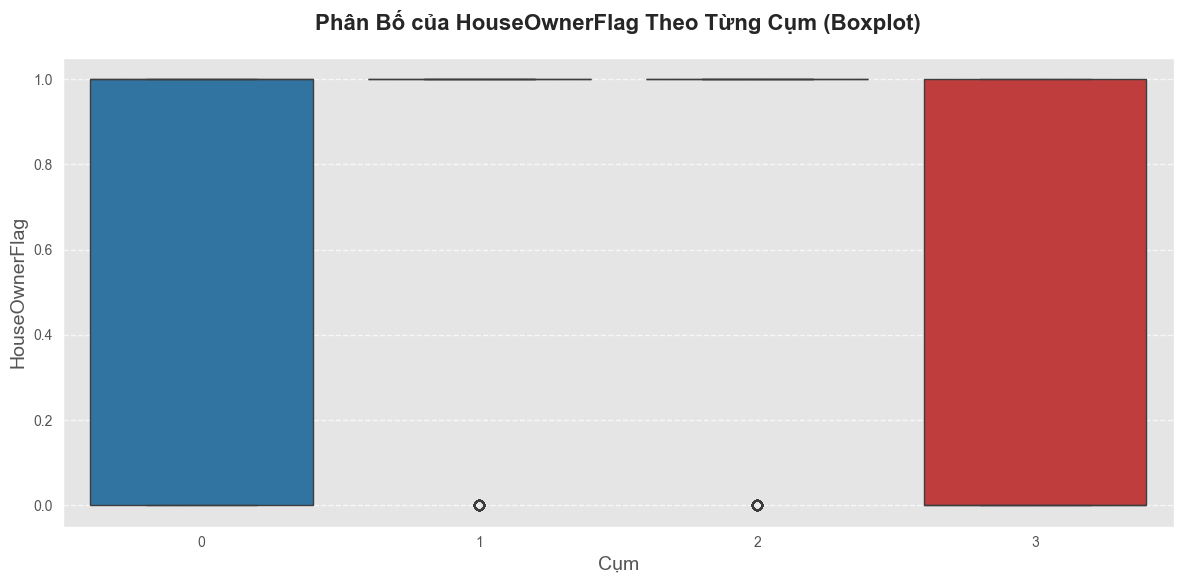

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




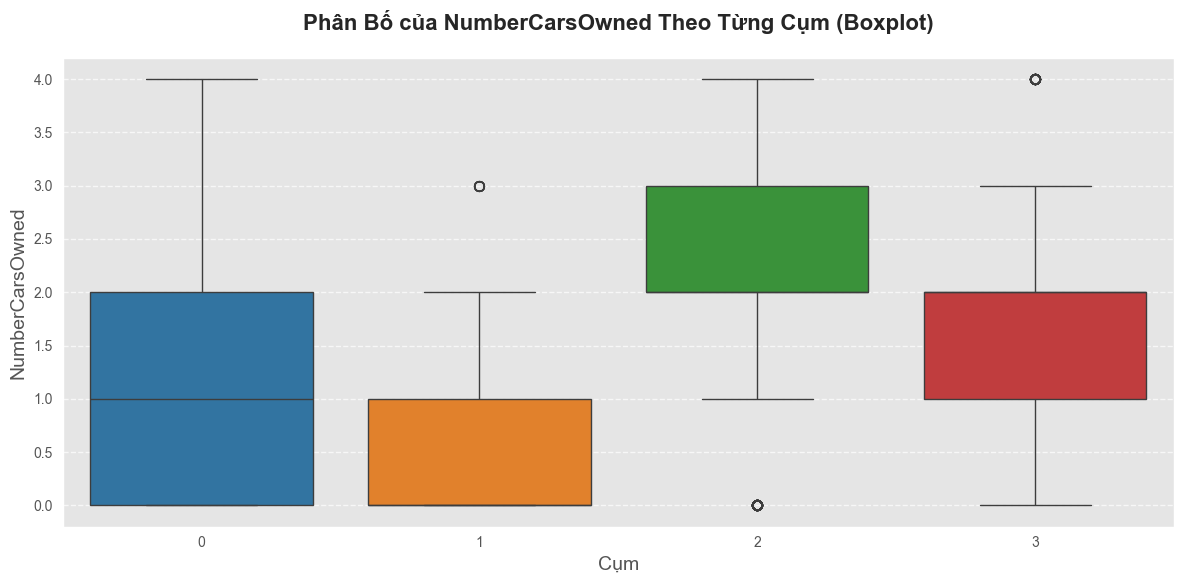

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




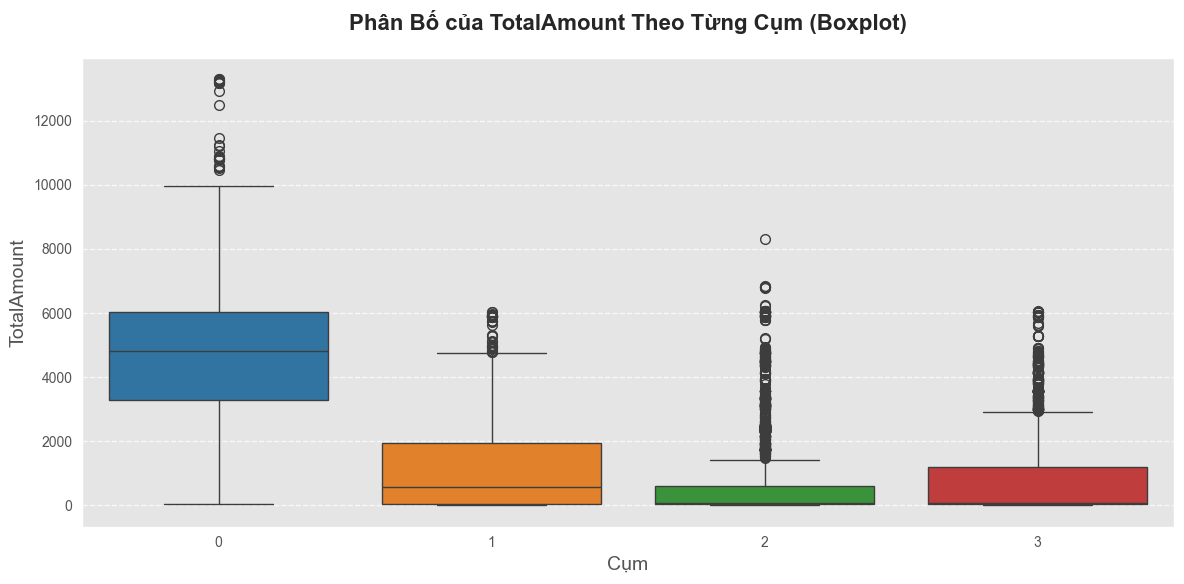

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




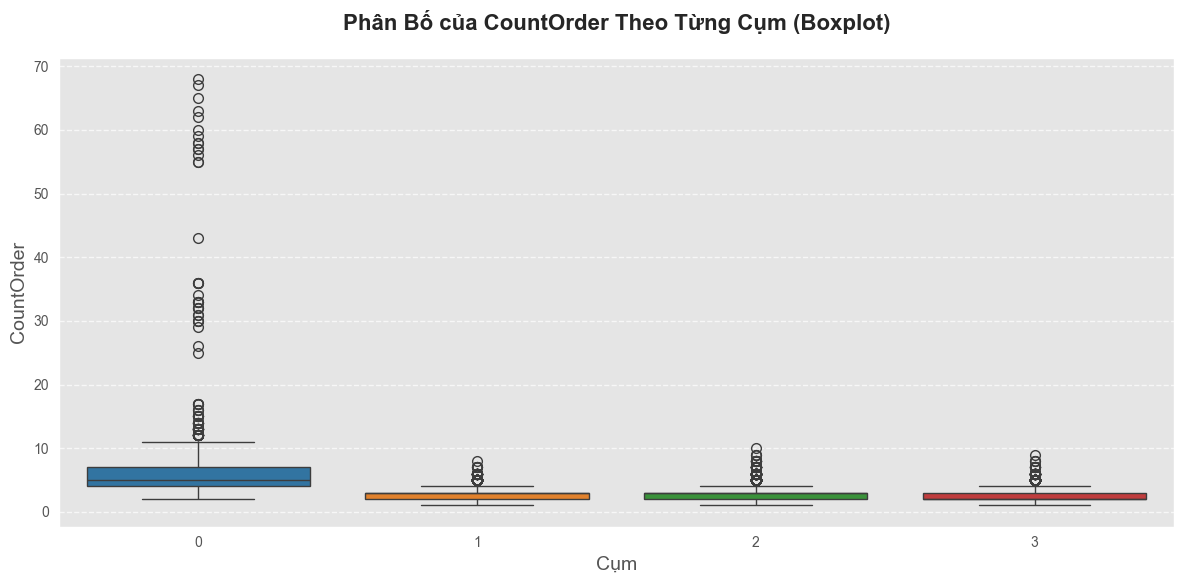

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




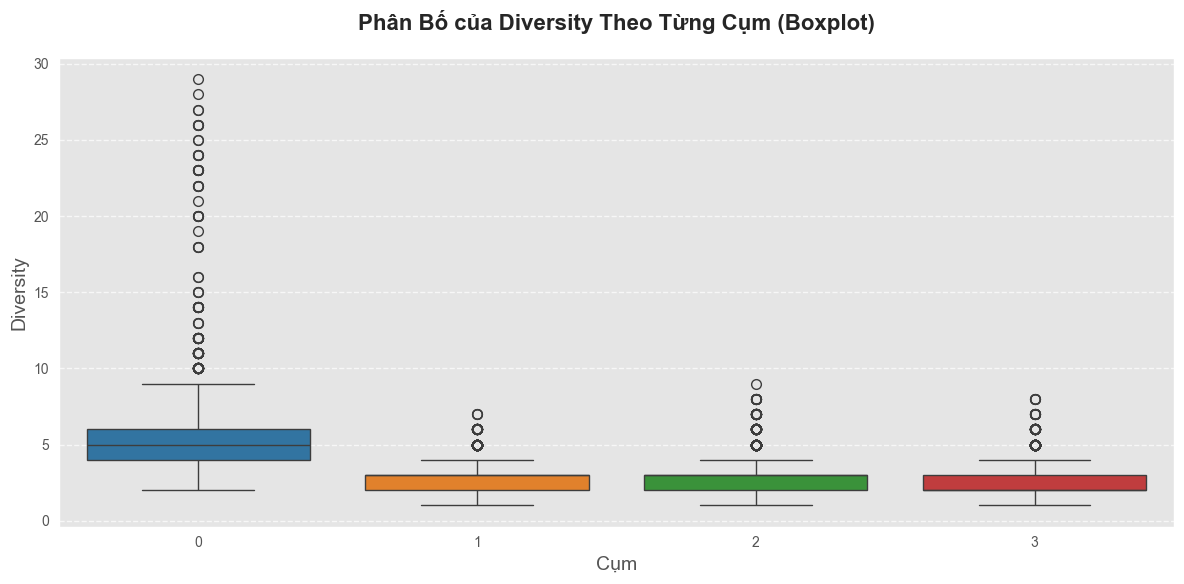

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




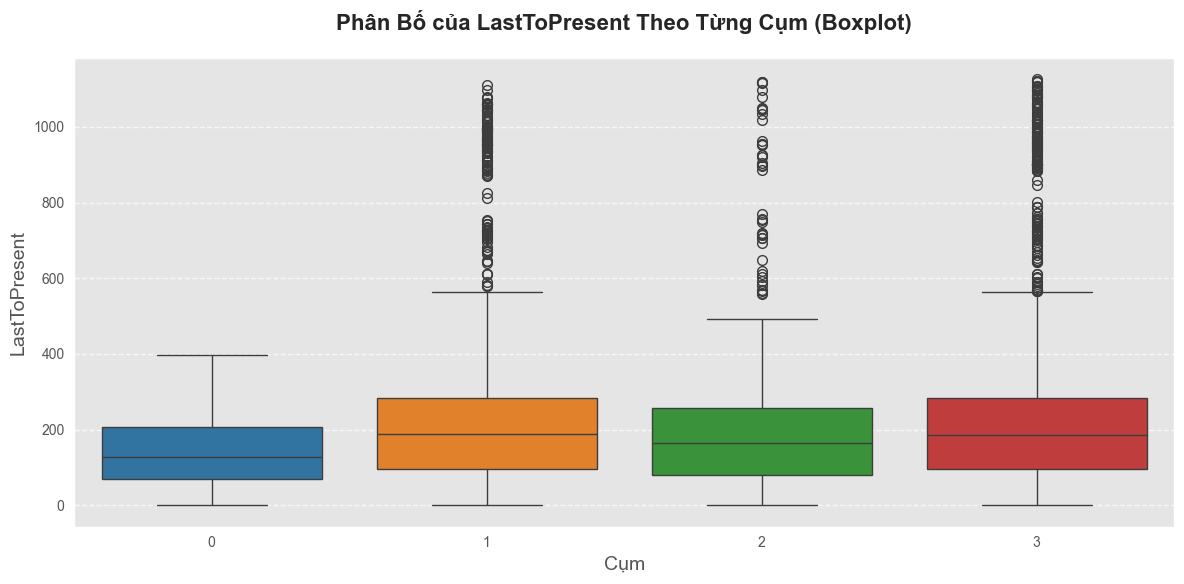

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




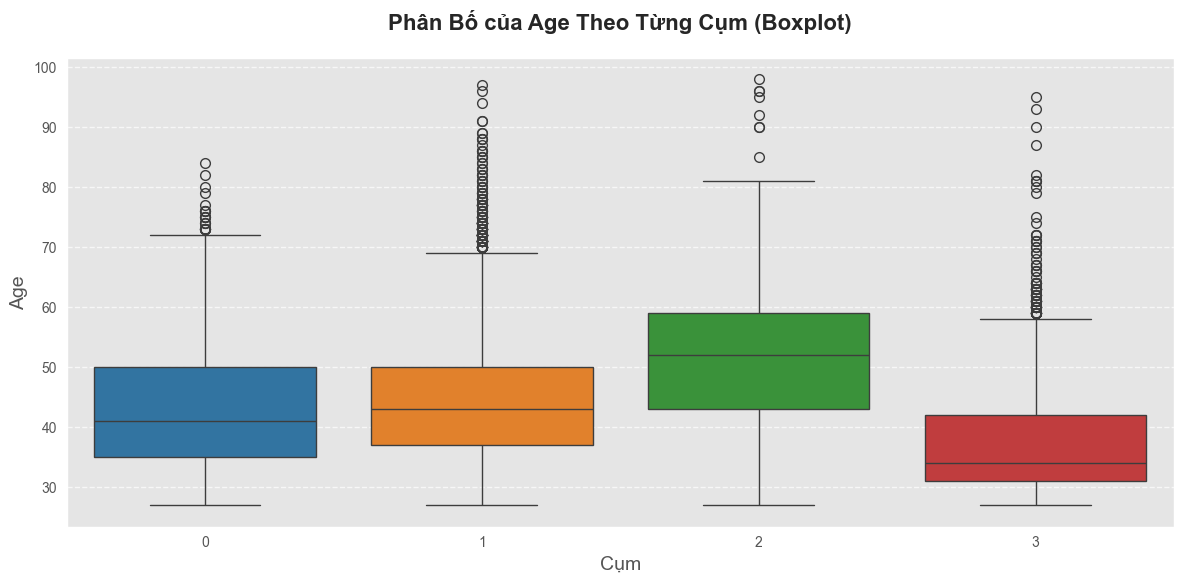

C:\Users\NITRO\AppData\Local\Temp\ipykernel_3364\1570290077.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




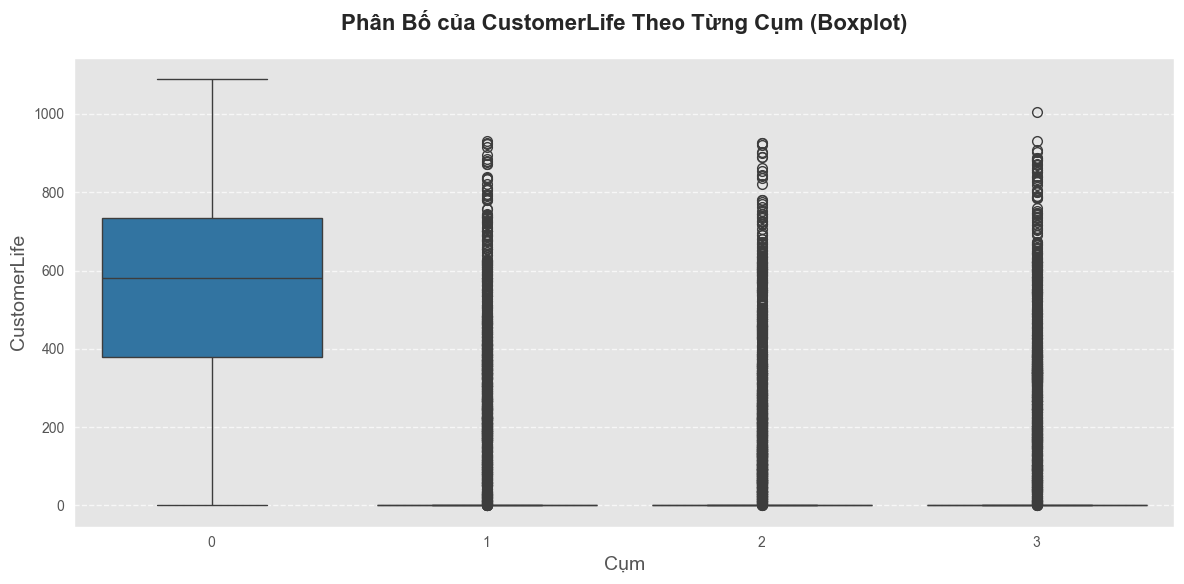

In [236]:
plt.style.use('ggplot')  
sns.set_palette("Set2")  
cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.rcParams['figure.figsize'] = (12, 6)  
plt.rcParams['font.size'] = 12  
plt.rcParams['axes.titlesize'] = 16  
plt.rcParams['axes.labelsize'] = 14  

numeric_columns = df_new_customer.select_dtypes(include=np.number).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['Cluster', 'CustomerKey', 'GeographyKey']]

cluster_median = df_new_customer.groupby('Cluster')[numeric_columns].median(numeric_only=True)
for col in numeric_columns:
  fig, ax = plt.subplots(figsize=(12, 6))
  sns.boxplot(x='Cluster', y=col, data=df_new_customer, ax=ax, palette=cluster_colors)
  ax.set_title(f'Phân Bố của {col} Theo Từng Cụm (Boxplot)', fontsize=16, fontweight='bold', pad=20)
  ax.set_xlabel('Cụm', fontsize=14)
  ax.set_ylabel(f'{col}', fontsize=14)
  ax.grid(True, axis='y', linestyle='--', alpha=0.7)

  plt.tight_layout()
  plt.show()

### Time Series Analysis

In [4]:
#Trích xuất dữ liệu theo doanh thu theo ngày
df_orderdate = df_internetsale.groupby('OrderDate')['SalesAmount'].sum().reset_index(name='Revenue').set_index('OrderDate')
df_orderdate.index = pd.to_datetime(df_orderdate.index)
df_orderdate = df_orderdate.asfreq('D') #Đưa dữ liệu về tần suất theo ngày

In [ ]:
#Kiểm tra giá trị null (vì đã được thêm ngày để đảm bảo tính liên tục)
df_orderdate['Revenue'].isnull().sum()

3

In [5]:
#Thay thế giá trị null bằng mồ doanh thu trung bình
df_orderdate = df_orderdate.fillna(np.mean(df_orderdate['Revenue']))

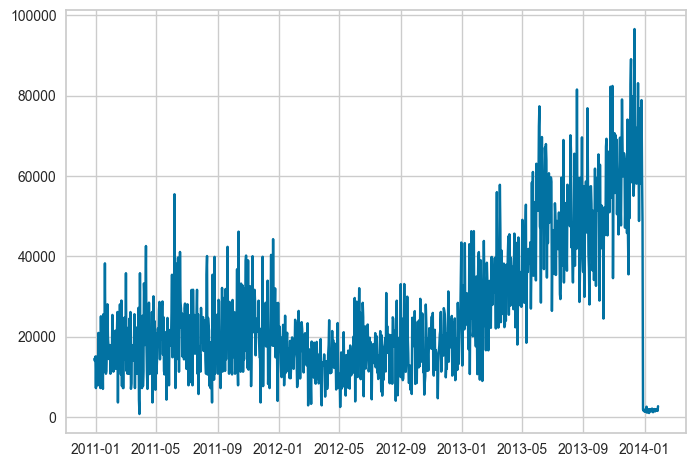

In [18]:
#Chuỗi thời gian sau khi fillNaN
plt.plot(df_orderdate)

Figure(800x550)


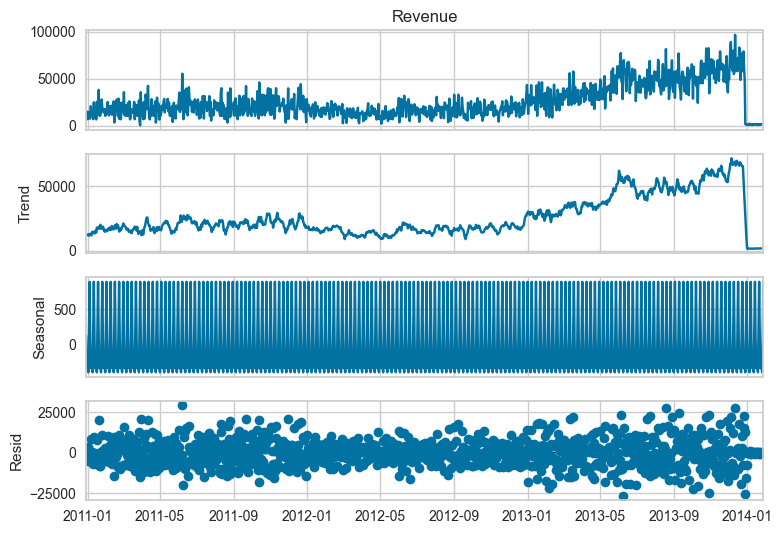

In [ ]:
#Phân tích tổng quan xu hướng, tính mùa vụ và nhiễu với chu kỳ 7 ngày
result_seasonal = seasonal_decompose(df_orderdate['Revenue'])
print(result_seasonal.plot())

Figure(800x550)


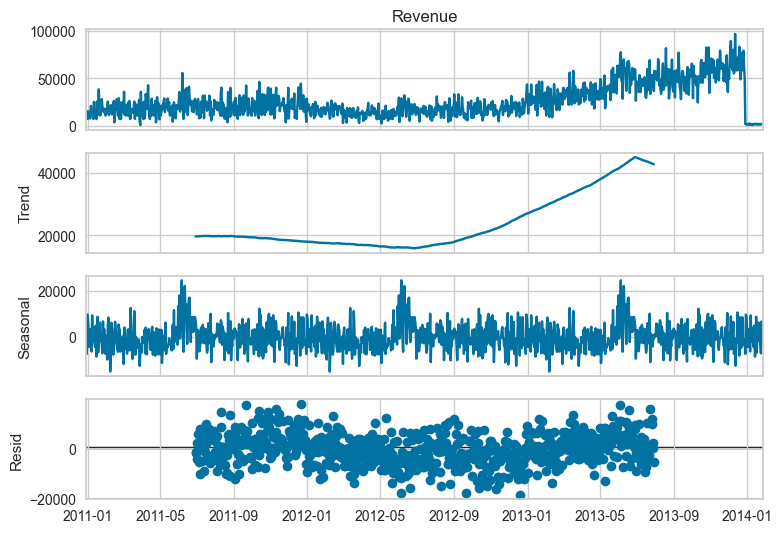

In [153]:
#Phân tích tổng quan xu hướng, tính mùa vụ và nhiễu với chu kỳ 30 ngày
result_seasonal = seasonal_decompose(df_orderdate['Revenue'], period=365)
print(result_seasonal.plot())

Figure(800x550)
Figure(800x550)


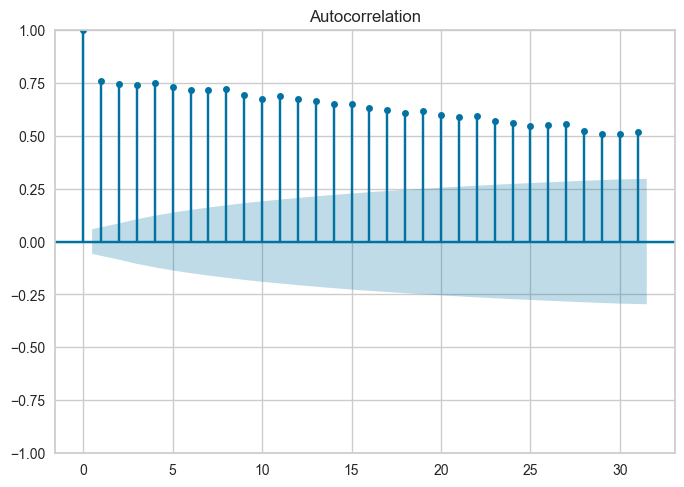

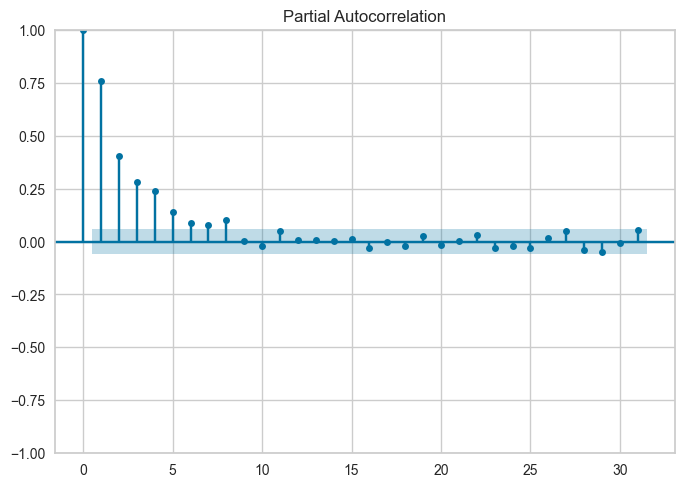

In [47]:
#Phân tích ACF và PACF
print(plot_acf(df_orderdate['Revenue']))
print(plot_pacf(df_orderdate['Revenue']))

In [ ]:
#Kiểm tra tính dừng của chuỗi thời gian
print(f'p-value: {adfuller(df_orderdate)[1]}')

#Nếu p-value < 0.05 thì chuỗi thời gian dừng

p-value: 0.10471441712482416


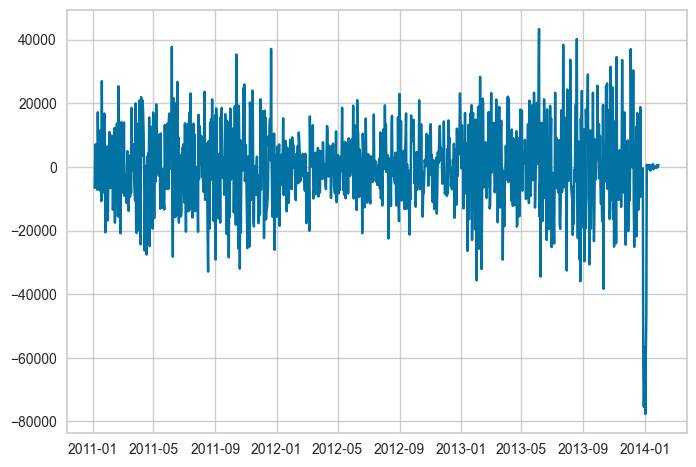

In [ ]:
#Vì chuỗi có tính mùa vụ theo tuần rõ rệt nên sẽ loại bỏ tính mùa vụ để chuỗi dừng
df_orderdate_diff = df_orderdate.diff(7).dropna()
plt.plot(df_orderdate_diff)

In [56]:
#Kiểm tra lại tính dừng
print(f'p-value: {adfuller(df_orderdate_diff)[1]}')

p-value: 5.384964256265918e-10


#### ARIMA Model

<function matplotlib.pyplot.show(close=None, block=None)>

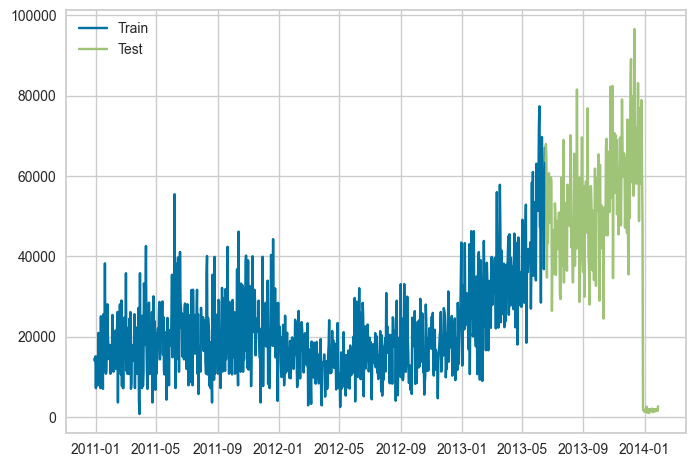

In [122]:
#Chia dữ liệu thành tập train và tập test với 80% train và 20% test
train_size = int(len(df_orderdate) * 0.8)
train = df_orderdate[:train_size]
test = df_orderdate[train_size:]

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend()
plt.show

In [123]:
#Xây dựng mô hình ARIMA bằng auto_arima
def arima_model (timeseries):
  automodel = pm.auto_arima(timeseries,
                            random_state=42,
                            start_p=0, max_p=7,
                            start_q=0, max_q=7,
                            start_P=0, max_P=2,
                            start_Q=0, max_Q=2,
                            D=1, #Sai phân bậc 1 của mùa vụ
                            n_jobs=-1,
                            test='adf', #Sử dụng kiểm đinh ADF
                            seasonal=True,
                            m=7, #Có tính mùa vụ theo tuần
                            trace=True)
  return automodel

c:\Users\NITRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=19196.279, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=19005.416, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=18873.513, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=19195.193, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=19196.191, Time=0.15 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=18875.496, Time=0.24 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=18875.503, Time=0.45 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=19005.824, Time=0.13 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=18876.044, Time=1.05 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=18791.248, Time=0.88 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=18875.136, Time=0.28 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=18875.101, Time=0.81 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=19004.120, Time=0.15 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=18876.293, Time=0.37 sec
 ARIMA(1,0,0)(0,1,1

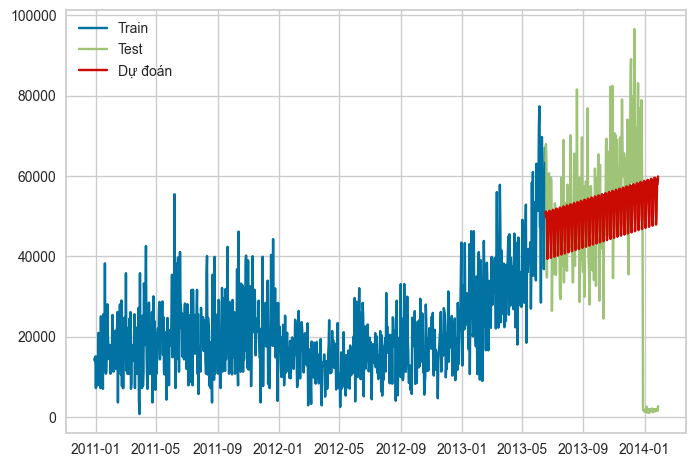

In [124]:
#Xử dụng trên tập train và dự báo số ngày bằng số ngày của tập test
model_train = arima_model(train)
forecast = model_train.predict(n_periods=len(test))
forecast = pd.Series(forecast, index=test.index)

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Dự đoán')
plt.legend()
plt.show()

In [64]:
mse_arima = mean_squared_error(test, forecast)
mae_arima = mean_absolute_error(test, forecast)
rmse_arima = root_mean_squared_error(test, forecast)
print(f'MSE Arima: {mse_arima}')
print(f'MAE Arima: {mae_arima}')
print(f'RMSE Arima: {rmse_arima}')

MSE Arima: 549608153.6719897
MAE Arima: 16404.26239414125
RMSE Arima: 23443.72311882201


c:\Users\NITRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=24388.091, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=24173.193, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=24104.917, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=24386.144, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=24378.517, Time=0.09 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=24103.915, Time=0.37 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=24183.199, Time=0.13 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=24100.657, Time=0.61 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=24138.099, Time=0.32 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=24102.391, Time=1.64 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=24102.339, Time=0.94 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=24155.674, Time=0.80 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=3.23 sec
 ARIMA(0,0,2)(2,1,1)[7] intercept   : AIC=24065.904, Time=0.84 sec
 ARIMA(0,0,2)(1,1,1)[7] i

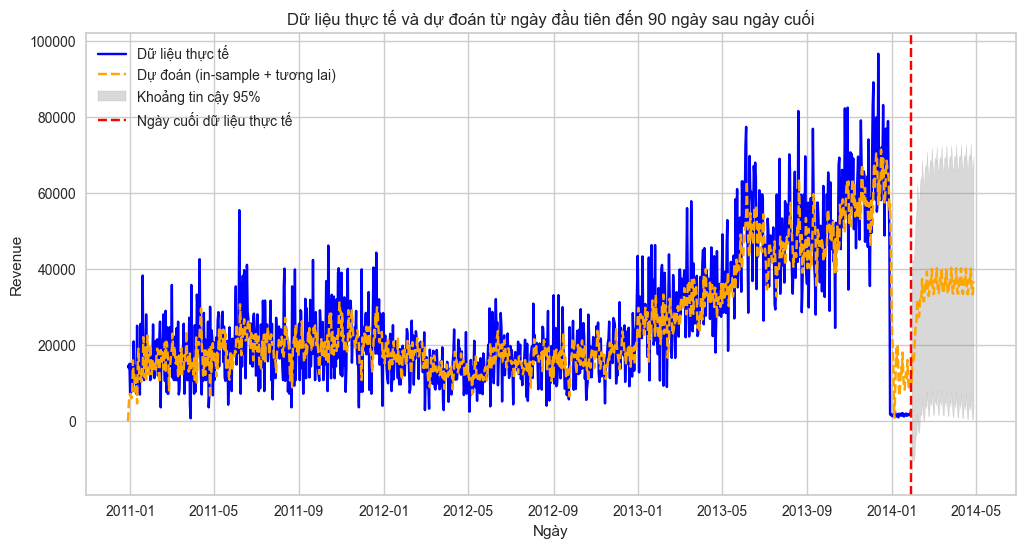

In [125]:
fitted_model = arima_model(df_orderdate)

in_sample_forecast = fitted_model.predict_in_sample()
in_sample_forecast = pd.Series(in_sample_forecast, index=df_orderdate.index)

future_steps = 90
future_forecast = fitted_model.predict(n_periods=future_steps, return_conf_int=True)

future_values = future_forecast[0]  # Giá trị dự đoán
conf_int = future_forecast[1]       # Khoảng tin cậy

last_date = df_orderdate.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

future_forecast_series = pd.Series(future_values, index=future_dates)

conf_int_df = pd.DataFrame(conf_int, index=future_dates, columns=['lower', 'upper'])

full_forecast = pd.concat([in_sample_forecast, future_forecast_series])

plt.figure(figsize=(12, 6))
plt.plot(df_orderdate, label='Dữ liệu thực tế', color='blue')
plt.plot(full_forecast, label='Dự đoán (in-sample + tương lai)', color='orange', linestyle='--')
plt.fill_between(future_dates, conf_int_df['lower'], conf_int_df['upper'], color='gray', alpha=0.3, label='Khoảng tin cậy 95%')
plt.axvline(x=last_date, color='red', linestyle='--', label='Ngày cuối dữ liệu thực tế')
plt.legend()
plt.title('Dữ liệu thực tế và dự đoán từ ngày đầu tiên đến 90 ngày sau ngày cuối')
plt.xlabel('Ngày')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [133]:
print(f'Tổng doanh thu của 3 tháng tiếp theo là: {future_forecast_series.sum():.1f}')

Tổng doanh thu của 3 tháng tiếp theo là: 3063175.1


#### Prophet Model

In [104]:
#Tạo 1 data frame mới làm đầu vào cho mô hình Prophet, vì nó yêu cầu 2 cột
df_prophet = df_orderdate.reset_index()
df_prophet.columns = ['ds', 'y']

train = df_prophet[:train_size]
test = df_prophet[train_size:]

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (c:\Users\NITRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\NITRO\AppData\Local\Temp\tmp8jvnywd4\d43q7i5z.json
DEBUG:cmdstanpy:input tempfile: C:\Users\NITRO\AppData\Local\Temp\tmp8jvnywd4\i_6onkz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\NITRO\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=69154', 'data', 'file=C:\\Users\\NITRO\\AppData\\Local\\Temp\\tmp8jvnywd4\\d43q7i5z.json', 'init=C:\\Users\\NITRO\\AppData\\Local\\Temp\\tmp8jvnywd4\\i_6onkz2.json', 'output', 'file=C:\\Users\\NITRO\\AppData\\Local\\Temp\\tmp8jvnywd4\\prophet_modelmor

RMSE Prophet: 22993.123379786673
MAE Prophet: 16823.58436933254
MSE Prophet: 528683722.7580926


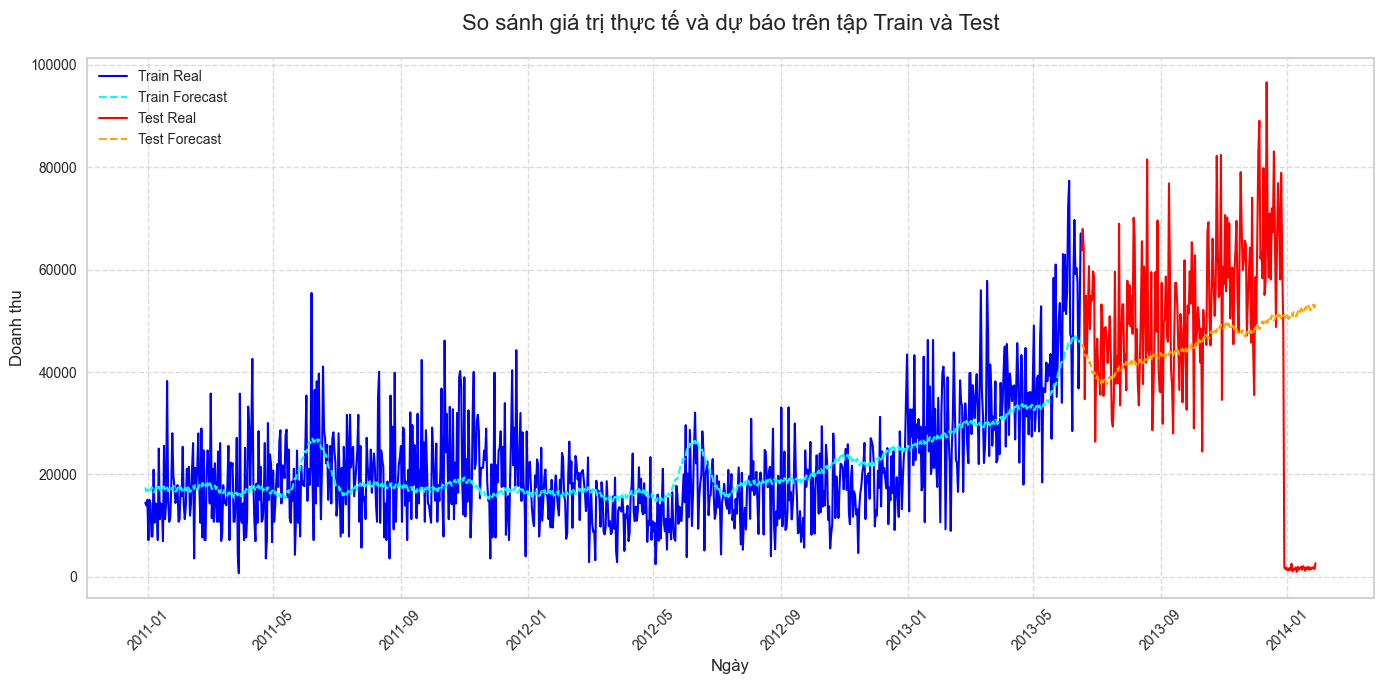

In [105]:
prophet_model = Prophet(changepoint_prior_scale=0.01,
                        seasonality_prior_scale=10)

prophet_model.add_seasonality(name='week', period=7, fourier_order=10)

prophet_model.fit(train)

future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
forecast = prophet_model.predict(future)

test_forecast = forecast.tail(len(test))
train_forecast = forecast[forecast['ds'].isin(train['ds'])]['yhat']
rmse_prophet = root_mean_squared_error(test['y'], test_forecast['yhat'])
mae_prophet = mean_absolute_error(test['y'], test_forecast['yhat'])
mse_prophet = mean_squared_error(test['y'], test_forecast['yhat'])
print(f"RMSE Prophet: {rmse_prophet}")
print(f"MAE Prophet: {mae_prophet}")
print(f"MSE Prophet: {mse_prophet}")


sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

plt.plot(train['ds'], train['y'], label='Train Real', color='blue', linewidth=1.5)
plt.plot(train['ds'], train_forecast, label='Train Forecast', color='cyan', linestyle='--', linewidth=1.5)
plt.plot(test['ds'], test['y'], label='Test Real', color='red', linewidth=1.5)
plt.plot(test['ds'], test_forecast['yhat'], label='Test Forecast', color='orange', linestyle='--', linewidth=1.5)

plt.title('So sánh giá trị thực tế và dự báo trên tập Train và Test', fontsize=16, pad=20)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Doanh thu', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\NITRO\AppData\Local\Temp\tmp8jvnywd4\vasvhpwp.json
DEBUG:cmdstanpy:input tempfile: C:\Users\NITRO\AppData\Local\Temp\tmp8jvnywd4\kxrn9sfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\NITRO\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=78308', 'data', 'file=C:\\Users\\NITRO\\AppData\\Local\\Temp\\tmp8jvnywd4\\vasvhpwp.json', 'init=C:\\Users\\NITRO\\AppData\\Local\\Temp\\tmp8jvnywd4\\kxrn9sfk.json', 'output', 'file=C:\\Users\\NITRO\\AppData\\Local\\Temp\\tmp8jvnywd4\\prophet_model0nxkxv80\\prophet_model-20250403000055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:00:55 - cmdstanpy - INFO - 

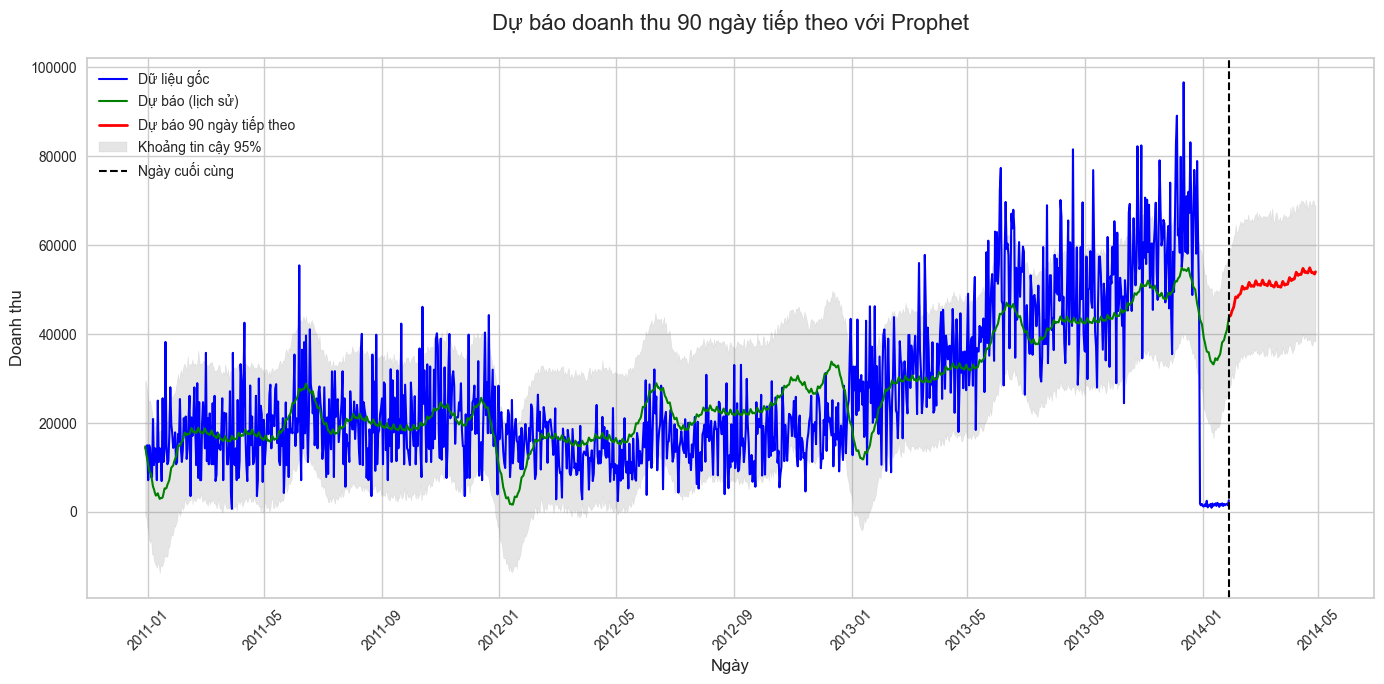

In [107]:
prophet_model = Prophet(changepoint_prior_scale=0.01,
                        seasonality_prior_scale=10)

prophet_model.add_seasonality(name='week', period=7, fourier_order=5)
prophet_model.fit(df_prophet)

future = prophet_model.make_future_dataframe(periods=90, freq='D')
forecast = prophet_model.predict(future)
forecast_90_days = forecast.tail(90)

sns.set_style("whitegrid")  
plt.figure(figsize=(14, 7))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Dữ liệu gốc', color='blue', linewidth=1.5)
plt.plot(forecast['ds'][:-90], forecast['yhat'][:-90], label='Dự báo (lịch sử)', color='green', linewidth=1.5)
plt.plot(forecast_90_days['ds'], forecast_90_days['yhat'], label='Dự báo 90 ngày tiếp theo', color='red', linewidth=2)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='gray', alpha=0.2, label='Khoảng tin cậy 95%')

last_date = df_prophet['ds'].iloc[-1]
plt.axvline(x=last_date, color='black', linestyle='--', label='Ngày cuối cùng', linewidth=1.5)

plt.title('Dự báo doanh thu 90 ngày tiếp theo với Prophet', fontsize=16, pad=20)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Doanh thu', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [119]:
print(f'Tổng doanh thu của 3 tháng tiếp theo là: {forecast_90_days["yhat"].sum():.1f}')

Tổng doanh thu của 3 tháng tiếp theo là: 4615760.7


#### LSTM

In [69]:
train_size = int(0.8 * len(df_orderdate))
train = df_orderdate[:train_size]['Revenue'].values
test = df_orderdate[train_size:]['Revenue'].values

In [76]:
#Chuẩn hóa dữ liệu
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.reshape(-1,1))
test_scaled = scaler.transform(test.reshape(-1,1))

In [80]:
def get_data(train,test,time_step,num_predict):
  X_train= list()
  y_train = list()
  X_test = list()
  y_test = list()

  for i in range(0,len(train) - time_step - num_predict):
    X_train.append(train[i:i+time_step])
    y_train.append(train[i+time_step:i+time_step+num_predict])

  for i in range(0, len(test) - time_step - num_predict):
    X_test.append(test[i:i+time_step])
    y_test.append(test[i+time_step:i+time_step+num_predict])

  return np.asarray(X_train), np.asarray(y_train), np.asarray(X_test), np.asarray(y_test)

In [81]:
X_train, y_train, X_test, y_test = get_data(train,test,60,1)

X_train = X_train.reshape(-1,60)
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)

X_test = X_test.reshape(-1,60)
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)

X_train = X_train.reshape(-1,60,1)
y_train = y_train.reshape(-1,1)

X_test = X_test.reshape(-1,60,1)
y_test = y_test.reshape(-1,1)

In [91]:
n_input = 60
n_features = 1

model = Sequential([
  Bidirectional(LSTM(128, activation='tanh', input_shape=(n_input, n_features), return_sequences=True,
                       kernel_regularizer=regularizers.l2(0.01))),
  Dropout(0.1),
  Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
  Dropout(0.1),
  LSTM(64, return_sequences=True),
  LSTM(64),
  Dense(1)
])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\NITRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [92]:
model.fit(X_train, y_train, batch_size=32, epochs=500, validation_split=0.2, verbose=1)
model.save('model/lstm.h5')

Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - loss: 6.2785 - val_loss: 4.6543
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 3.0644 - val_loss: 3.1813
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 1.5014 - val_loss: 2.7335
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.8399 - val_loss: 2.0719
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.5962 - val_loss: 1.9107
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.4742 - val_loss: 1.6489
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.4232 - val_loss: 2.0291
Epoch 8/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.4992 - val_loss: 2.0739
Epoch 9/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.4679 - val_loss: 2.1648
Epoch 10/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.4356 - val_loss: 2.0567
Epoch 11/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.4516 - val_loss: 2.0873
Epoch 12/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 10

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step


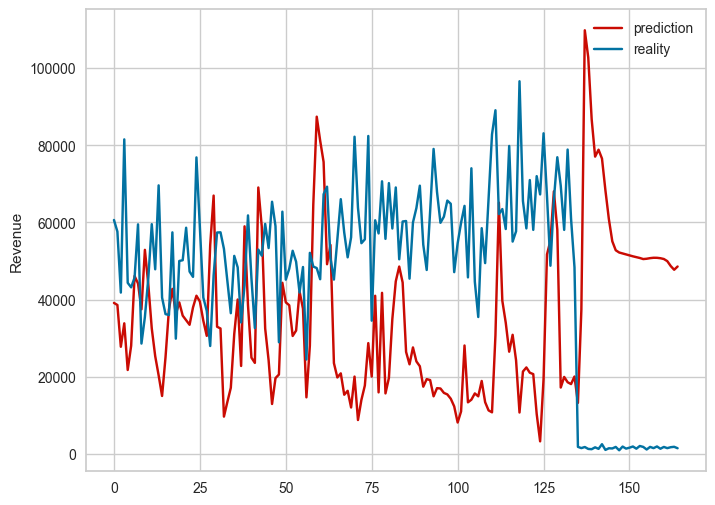

In [98]:
lstm_model = keras.models.load_model('model/lstm.h5')

y_pred_scaled = lstm_model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_origin = scaler.inverse_transform(y_test)

plt.figure(figsize=(8,6))
plt.plot(y_pred, color='r')
plt.plot(y_test_origin ,color='b')
plt.ylabel("Revenue")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()

In [94]:
mse_lstm = mean_squared_error(y_test_origin, y_pred)
mae_lstm = mean_absolute_error(y_test_origin, y_pred)
rmse_lstm = root_mean_squared_error(y_test_origin, y_pred)
print("MSE LSTM:", mse_lstm)
print("MAE LSTM:", mae_lstm)
print('RMSE LSTM:', rmse_lstm)

MSE LSTM: 1596466201.119579
MAE LSTM: 34194.68988778409
RMSE LSTM: 39955.80309691671


In [100]:
future_days = 90
last_sequence = train_scaled[-60:]
forecast = []
for _ in range(future_days):
  next_value = lstm_model.predict(last_sequence.reshape(1, 60, 1))
  forecast.append(next_value[0])
  last_sequence = np.append(last_sequence[1:], next_value, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

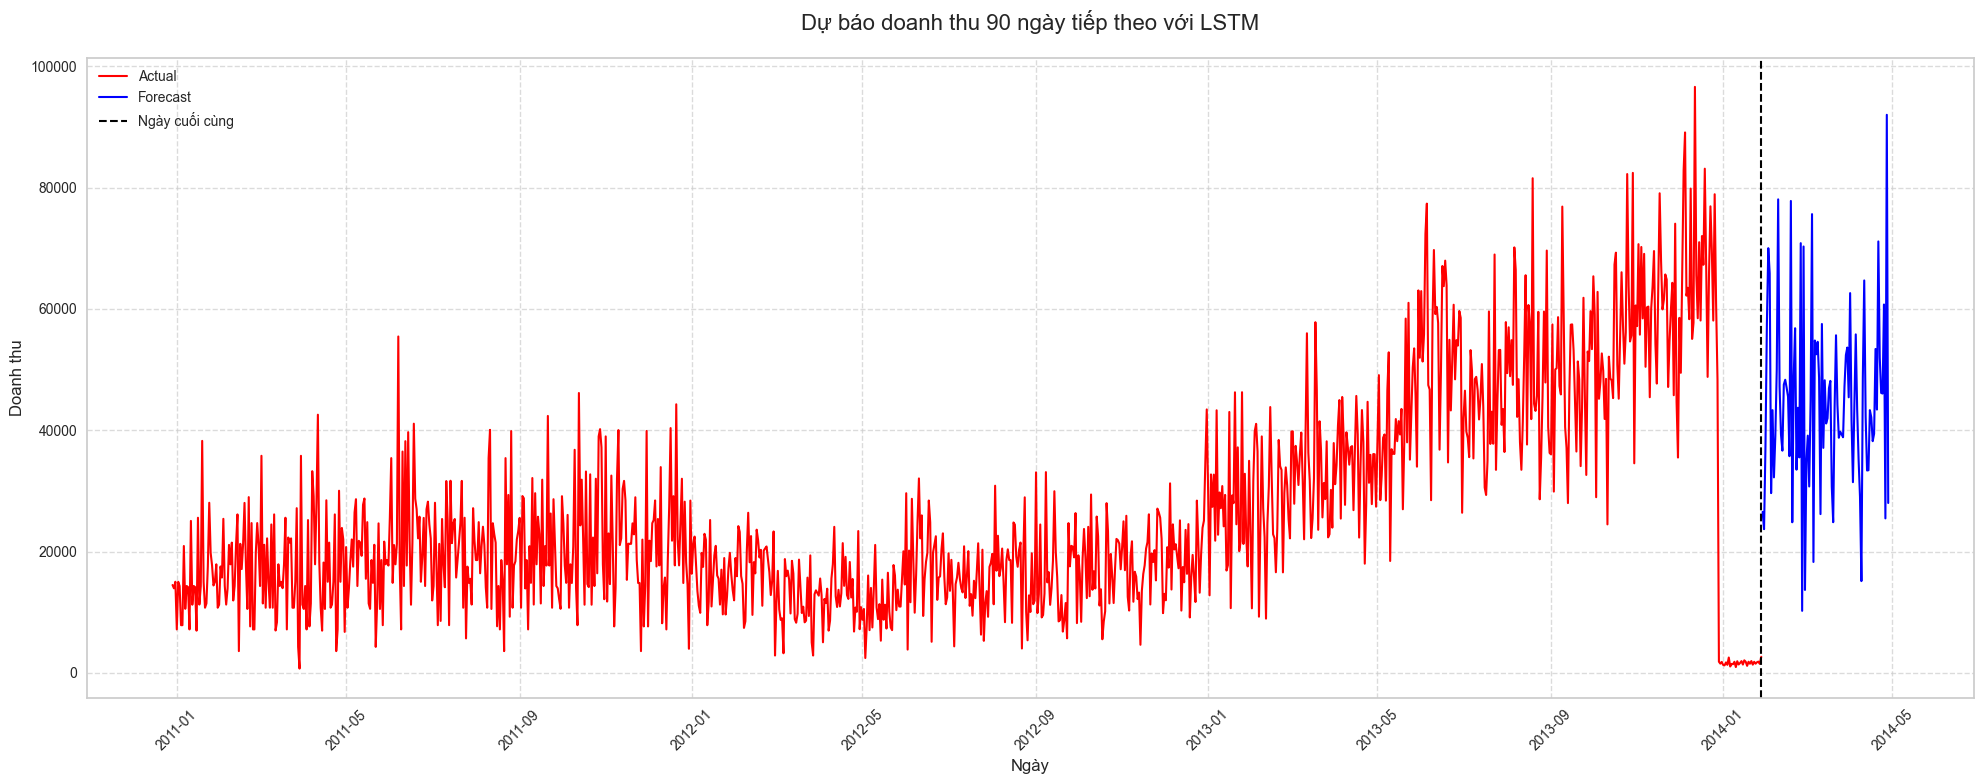

In [ ]:
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

last_date = pd.to_datetime('2014-01-28')
index = pd.date_range(start=last_date, periods=future_days+1)
index = index[1:]

forecast_df = pd.DataFrame(forecast, index=index, columns=['Forecast'])
actual_value = df_orderdate

plt.figure(figsize=(20, 8))

plt.plot(actual_value.index, actual_value['Revenue'], label='Actual', color='red', linewidth=1.5)
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='blue', linewidth=1.5)
plt.axvline(x=last_date, color='black', linestyle='--', label='Ngày cuối cùng', linewidth=1.5)

plt.title('Dự báo doanh thu 90 ngày tiếp theo với LSTM', fontsize=16, pad=20)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Doanh thu', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [121]:
print(f'Tổng doanh thu của 3 tháng tiếp theo là: {forecast_df["Forecast"].sum():.1f}')

Tổng doanh thu của 3 tháng tiếp theo là: 4003968.5
